# Week 2

As explained in Lecture 1, each week of this class is a Jupyter notebook like this one. In order to follow the class, you simply start reading from the top, following the instructions.

## Today

This lecture covers:

1. **Principles of good visualization**: We'll watch a video on what makes plots effective and create your own checklist.
2. **Merging messy real-world datasets**: You'll combine SF crime data from two different time periods (2003-2018 and 2018-present) that use different schemas and categories. This is one of the most common and frustrating tasks in data science.
3. **Temporal pattern analysis**: Using your merged 20+ year dataset, you'll explore crime patterns across years, months, weekdays, and hours.
4. **Advanced visualization techniques**: You'll experiment with calendar plots, polar charts, and time series visualizations.

By the end, you'll have a unified crime dataset spanning two decades and the skills to wrangle similarly messy data in your future work.

## Part 1: Creating nice plots

Ok. There's a lot of barcharts today. We need them ... they are a fantastic tool for data exploration. But it can get monotonous, so let's take a little break to talk about something else before digging deeper with the barcharts.

I want to tell you a bit about how to make nice plots. I do that in the video below

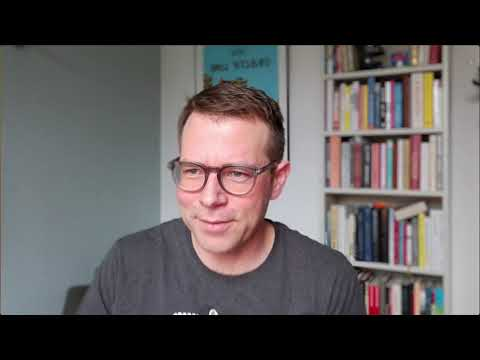

In [46]:
from IPython.display import YouTubeVideo
YouTubeVideo('9hIu4pgJXQc', width=800, height=450)

> **Exercise 1.1**: Nice plots
>
> * Create a list of 10 rules for nice plots based on the video.

* Tight layout command
* Leverage subplots, and make them comparable (same ax dimension) if possible
* Add labels to all axes and captions if appliable
* Use meaningful values for axe range (proportional space, interval, good range, physical sense, magnitude)
* Zoom level: Zoom level just be adjusted to the real meaningful and difference between values!!! 
* Zoom level in subplots --> Always plot on comparable axes or, ifnot, indicate in some kind of caption
* Data to ink ratio: don't do superflous stuff --> Above all else show the data; maximize data-ink ratio; erase non-data ink; erase redundant data-ink; revise and edit
* Font
* Captions, explanations in legends, etc. In subplots, first general explanation and then, for each subplot, specify the info displayed in particular.

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> Answer in your own words, do your own research, don't use your LLM. Once you've written down your answers, it's OK to use the LLM to refine your writing.
</div>

## Part 2: Merging Historical and Recent Crime Data

So far we've been working with crime data from 2018 onwards (I will assume you have that file, named something like "Police Department Incident Reports 2018 to Present"). But San Francisco has published crime data going all the way back to 2003! Having access to this longer time series would let us:
- Study long-term trends in crime
- See how crime patterns changed before, during, and after major events
- Have more statistical power for our analyses

The catch? **The two datasets don't have the same structure.** This is an incredibly common situation in data science. Organizations change how they record data over time, different departments use different formats, and merging datasets requires careful thought.

### Why This Matters

In the real world, you'll almost never get a single, clean dataset that answers your question. Instead, you'll need to combine data from multiple sources: different time periods, different departments, different organizations. Each source will have its own quirks, naming conventions, and missing values.

This is also directly relevant to algorithmic accountability. Remember the Richardson et al. reading from Week 1? They argued that "dirty data" undermines predictive policing. But what counts as "dirty"? If crime categories change over time—if `DRUNKENNESS` disappears as a category in 2018—does that mean public intoxication stopped? Or just that we can't track it anymore? These are the kinds of questions you need to ask whenever you merge datasets.

The skills you'll practice here—schema mapping, category matching, validation—are foundational for any serious data work.

### Step 2.1: Understand both schemas

> **Mini Exercise**: Schema exploration
>
> Download the historical dataset "Police Department Incident Reports: Historical 2003 to May 2018" from SF OpenData (or use the file provided).
>
> * Load both datasets and examine their columns
> * Which columns appear in both datasets (perhaps with different names)?
> * Which columns are unique to each dataset?
> * Create a "mapping" showing which columns in the historical data correspond to which columns in the recent data

Here's a starter to help you think about the mapping:

| Information | Historical Column | Recent Column |
|-------------|------------------|---------------|
| Crime type | `Category` | `Incident Category` |
| Police district | `PdDistrict` | `Police District` |
| Date | `Date` | `Incident Date` |
| ... | ... | ... |

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> You should be able to do this no problem in pandas, but if you find it tough, feel free to ask an LLM for help.
</div>

In [47]:
import pandas as pd
from pathlib import Path

# 1) Load both datasets
# Adjust names if your files differ

recent_path = Path(r"C:\Users\slupo\OneDrive\Documentos\DTU\Social data analysis and visualization") / "Police_Department_Incident_Reports__2018_to_Present_20260204.csv"
hist_path = Path(r"C:\Users\slupo\OneDrive\Documentos\DTU\Social data analysis and visualization") / "Police_Department_Incident_Reports__Historical_2003_to_May_2018_20260212.csv"

recent = pd.read_csv(recent_path, low_memory=False)
hist = pd.read_csv(hist_path, low_memory=False)

# 2) Normalize column names (same approach as Week1)
recent.columns = [c.strip().lower() for c in recent.columns]
hist.columns = [c.strip().lower() for c in hist.columns]

recent_cols = set(recent.columns)
hist_cols = set(hist.columns)

print("Recent columns:", len(recent_cols), )
print("Historical columns:", len(hist_cols))


Recent columns: 29
Historical columns: 15


In [48]:
# 3) Exact common and unique columns
common_exact = sorted(hist_cols & recent_cols)
only_hist = sorted(hist_cols - recent_cols)
only_recent = sorted(recent_cols - hist_cols)

print("\n=== Exact common column names ===")
for c in common_exact:
    print(c)

print("\n=== Only in historical ===")
for c in only_hist:
    print(c)

print("\n=== Only in recent ===")
for c in only_recent:
    print(c)



=== Exact common column names ===
data_loaded_at
incident code
resolution

=== Only in historical ===
address
category
date
dayofweek
descript
incidntnum
location
pddistrict
pdid
time
x
y

=== Only in recent ===
analysis neighborhood
cad number
cnn
data_as_of
filed online
incident category
incident date
incident datetime
incident day of week
incident description
incident id
incident number
incident subcategory
incident time
incident year
intersection
latitude
longitude
point
police district
report datetime
report type code
report type description
row id
supervisor district
supervisor district 2012


In [49]:
# 4) Manual mapping for essential analysis fields (Week1 + future mapping work)
def pick_col(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

mapping_rows = [
    ("Row identifier", pick_col(hist_cols, ["pdid"]), pick_col(recent_cols, ["row id"])),
    ("Incident ID", pick_col(hist_cols, ["incidntnum"]), pick_col(recent_cols, ["incident id"])),
    ("Incident code", pick_col(hist_cols, ["incident code"]), pick_col(recent_cols, ["incident code"])),
    ("Crime type", pick_col(hist_cols, ["category"]), pick_col(recent_cols, ["incident category"])),
    ("Description", pick_col(hist_cols, ["descript"]), pick_col(recent_cols, ["incident description"])),
    ("Police district", pick_col(hist_cols, ["pddistrict"]), pick_col(recent_cols, ["police district"])),
    ("Date", pick_col(hist_cols, ["date"]), pick_col(recent_cols, ["incident date"])),
    ("Day of week", pick_col(hist_cols, ["dayofweek"]), pick_col(recent_cols, ["incident day of week"])),
    ("Time", pick_col(hist_cols, ["time"]), pick_col(recent_cols, ["incident time"])),
    ("Latitude", pick_col(hist_cols, ["y", "latitude"]), pick_col(recent_cols, ["latitude"])),
    ("Longitude", pick_col(hist_cols, ["x", "longitude"]), pick_col(recent_cols, ["longitude"])),
    ("Location", pick_col(hist_cols, ["location"]), pick_col(recent_cols, ["point"])),
    ("Address", pick_col(hist_cols, ["address"]), pick_col(recent_cols, ["address", "intersection"])),
    ("Resolution", pick_col(hist_cols, ["resolution"]), pick_col(recent_cols, ["resolution"])),
    ("Data loaded at", pick_col(hist_cols, ["data_loaded_at"]), pick_col(recent_cols, ["data_loaded_at"]))
]

mapping_df = pd.DataFrame(mapping_rows, columns=["information", "historical_column", "recent_column"])
mapping_df


information historical_column         recent_column
0    Row identifier              pdid                row id
1       Incident ID        incidntnum           incident id
2     Incident code     incident code         incident code
3        Crime type          category     incident category
4       Description          descript  incident description
5   Police district        pddistrict       police district
6              Date              date         incident date
7       Day of week         dayofweek  incident day of week
8              Time              time         incident time
9          Latitude                 y              latitude
10        Longitude                 x             longitude
11         Location          location                 point
12          Address           address          intersection
13       Resolution        resolution            resolution
14   Data loaded at    data_loaded_at        data_loaded_at

## Step 2.2: Identify the common ground

> **Mini Exercise**: Essential columns
>
> * For the analyses we've have been doing (crime categories, time patterns, police districts), and *will be doing in future lectures* (**mapping GPS points**) which columns do we need?
> * Make a list of the essential/potentially interesting columns and their names in each dataset
> * Check the data types — are dates stored the same way? Are coordinates in the same format?
> * Handle any format differences (hint: look carefully at how dates are formatted in each file)

In [50]:
# Step 2.2 — Essential columns table (from your mapping)
essential = pd.DataFrame(
    [
        ("ID / dedup", "pdid", "row id"),
        ("Incident identifier", "incidntnum", "incident id"),
        ("Legal code", "incident code", "incident code"),
        ("Crime category", "category", "incident category"),
        ("Crime description", "descript", "incident description"),
        ("District", "pddistrict", "police district"),
        ("Date", "date", "incident date"),
        ("Day of week", "dayofweek", "incident day of week"),
        ("Time", "time", "incident time"),
        ("Latitude", "y", "latitude"),
        ("Longitude", "x", "longitude"),
        ("Geo point", "location", "point"),
        ("Location text", "address", "intersection"),
        ("Case status", "resolution", "resolution"),
        ("Ingestion metadata", "data_loaded_at", "data_loaded_at"),
    ],
    columns=["purpose", "historical_column", "recent_column"]
)
essential

purpose historical_column         recent_column
0            ID / dedup              pdid                row id
1   Incident identifier        incidntnum           incident id
2            Legal code     incident code         incident code
3        Crime category          category     incident category
4     Crime description          descript  incident description
5              District        pddistrict       police district
6                  Date              date         incident date
7           Day of week         dayofweek  incident day of week
8                  Time              time         incident time
9              Latitude                 y              latitude
10            Longitude                 x             longitude
11            Geo point          location                 point
12        Location text           address          intersection
13          Case status        resolution            resolution
14   Ingestion metadata    data_loaded_at        data_loaded_at

In [51]:
# Step 2.2 — Build aligned dataframes with a shared schema

hist_keep = [
    "pdid","incidntnum","incident code","category","descript","pddistrict",
    "date","dayofweek","time","y","x","location","address","resolution","data_loaded_at"
]
recent_keep = [
    "row id","incident id","incident code","incident category","incident description","police district",
    "incident date","incident day of week","incident time","latitude","longitude","point","intersection",
    "resolution","data_loaded_at","incident datetime", "incident year"
]

hist2 = hist[hist_keep].copy()
recent2 = recent[recent_keep].copy()

hist2 = hist2.rename(columns={
    "pdid": "row_id",
    "incidntnum": "incident_id",
    "incident code": "incident_code",
    "category": "incident_category",
    "descript": "incident_description",
    "pddistrict": "police_district",
    "date": "incident_date",
    "dayofweek": "incident_day_of_week",
    "time": "incident_time",
    "y": "latitude",
    "x": "longitude",
    "location": "point",
    "address": "location_text",
    "resolution": "resolution",
    "data_loaded_at": "data_loaded_at",
})

recent2 = recent2.rename(columns={
    "row id": "row_id",
    "incident id": "incident_id",
    "incident code": "incident_code",
    "incident category": "incident_category",
    "incident description": "incident_description",
    "police district": "police_district",
    "incident date": "incident_date",
    "incident day of week": "incident_day_of_week",
    "incident time": "incident_time",
    "latitude": "latitude",
    "longitude": "longitude",
    "point": "point",
    "intersection": "location_text",
    "resolution": "resolution",
    "data_loaded_at": "data_loaded_at",
    "incident datetime": "incident_datetime",
    "incident year": "incident_year"
})

In [52]:
# Ensure datetimelike first (safe even if already datetime)
hist2["incident_date"] = pd.to_datetime(hist2["incident_date"], errors="coerce")
recent2["incident_date"] = pd.to_datetime(recent2["incident_date"], errors="coerce")

# Normalize HH:MM text
def normalize_hhmm(series):
    s = series.astype(str).str.strip()
    parts = s.str.extract(r"^\s*(\d{1,2}):(\d{2})(?::\d{2})?\s*$")
    hhmm = parts[0].str.zfill(2) + ":" + parts[1]
    return hhmm.where(parts[0].notna(), pd.NA)

hist2["incident_time"] = normalize_hhmm(hist2["incident_time"])
recent2["incident_time"] = normalize_hhmm(recent2["incident_time"])

# Build historical incident_datetime
hist2["incident_datetime"] = pd.to_datetime(
    hist2["incident_date"].dt.strftime("%Y-%m-%d") + " " + hist2["incident_time"] + ":00",
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

# Parse recent incident_datetime + fallback from date+time
recent2["incident_datetime"] = pd.to_datetime(
    recent2["incident_datetime"],
    format="%Y/%m/%d %I:%M:%S %p",
    errors="coerce"
)

mask = recent2["incident_datetime"].isna() & recent2["incident_date"].notna() & recent2["incident_time"].notna()
recent2.loc[mask, "incident_datetime"] = pd.to_datetime(
    recent2.loc[mask, "incident_date"].dt.strftime("%Y-%m-%d") + " " + recent2.loc[mask, "incident_time"] + ":00",
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

# If you want incident_date as pure date only, do it at the very end:
hist2["incident_date"] = hist2["incident_date"].dt.date
recent2["incident_date"] = recent2["incident_date"].dt.date

hist2["incident_year"] = pd.to_datetime(hist2["incident_date"], errors="coerce").dt.year
recent2["incident_year"] = pd.to_datetime(recent2["incident_date"], errors="coerce").dt.year



In [53]:
hist2.head()

row_id  incident_id  incident_code incident_category  \
0  16020415607021    160204156           7021     VEHICLE THEFT   
1   6102672004134     61026720           4134           ASSAULT   
2  11049313327195    110493133          27195          TRESPASS   
3   5082289804134     50822898           4134           ASSAULT   
4   4072167065015     40721670          65015    OTHER OFFENSES   

  incident_description police_district incident_date incident_day_of_week  \
0    STOLEN AUTOMOBILE         TARAVAL    2016-03-03             Thursday   
1              BATTERY        NORTHERN    2006-09-25               Monday   
2          TRESPASSING         TARAVAL    2011-06-19               Sunday   
3              BATTERY       INGLESIDE    2005-07-23             Saturday   
4    TRAFFIC VIOLATION         MISSION    2004-06-24             Thursday   

  incident_time        latitude         longitude  \
0         19:30  37,70796836451  -122,46354501682   
1         22:15    37,778486375  -122,42583948035   
2         13:06   37,7291845796  -122,46675800516   
3         16:40  37,70831097444  -122,42008407525   
4         13:00              90            -120,5   

                                 point            location_text  \
0  POINT (-122.463545017 37.707968365)   100 Block of BEPLER ST   
1   POINT (-122.42583948 37.778486375)   400 Block of FULTON ST   
2   POINT (-122.466758005 37.72918458)    100 Block of APTOS AV   
3  POINT (-122.420084075 37.708310974)    GENEVA AV / SANTOS ST   
4                    POINT (-120.5 90)  FLORIDA ST / ALAMEDA ST   

      resolution          data_loaded_at   incident_datetime  incident_year  
0           NONE  2025/06/20 12:17:56 PM 2016-03-03 19:30:00           2016  
1           NONE  2025/06/20 12:17:56 PM 2006-09-25 22:15:00           2006  
2           NONE  2025/06/20 12:17:56 PM 2011-06-19 13:06:00           2011  
3           NONE  2025/06/20 12:17:56 PM 2005-07-23 16:40:00           2005  
4  ARREST, CITED  2025/06/20 12:17:56 PM 2004-06-24 13:00:00           2004

In [54]:
# Step 2.2 — Check type consistency and missingness

dtype_compare = pd.DataFrame({
    "historical_dtype": hist2.dtypes.astype(str),
    "recent_dtype": recent2.dtypes.astype(str)
})
display(dtype_compare)

quality = pd.DataFrame({
    "historical_missing_pct": (hist2.isna().mean() * 100).round(2),
    "recent_missing_pct": (recent2.isna().mean() * 100).round(2)
})
display(quality)

print("Historical date range:", hist2["incident_date"].min(), "to", hist2["incident_date"].max())
print("Recent date range:    ", recent2["incident_date"].min(), "to", recent2["incident_date"].max())

historical_dtype    recent_dtype
row_id                          int64           int64
incident_id                     int64           int64
incident_code                   int64           int64
incident_category                 str             str
incident_description              str             str
police_district                   str             str
incident_date                  object          object
incident_day_of_week              str             str
incident_time                     str             str
latitude                          str             str
longitude                         str             str
point                             str             str
location_text                     str             str
resolution                        str             str
data_loaded_at                    str             str
incident_datetime      datetime64[us]  datetime64[us]
incident_year                   int32           int32

historical_missing_pct  recent_missing_pct
row_id                                   0.0                0.00
incident_id                              0.0                0.00
incident_code                            0.0                0.00
incident_category                        0.0                0.15
incident_description                     0.0                0.00
police_district                          0.0                0.00
incident_date                            0.0                0.00
incident_day_of_week                     0.0                0.00
incident_time                            0.0                0.00
latitude                                 0.0                5.52
longitude                                0.0                5.52
point                                    0.0                5.52
location_text                            0.0                5.52
resolution                               0.0                0.00
data_loaded_at                           0.0                0.00
incident_datetime                        0.0                0.00
incident_year                            0.0                0.00

Historical date range: 2003-01-01 to 2018-05-15
Recent date range:     2018-01-01 to 2026-02-02


In [55]:
# Final aligned column order for later merge (Step 2.3+)

common_cols = [
    "row_id","incident_id","incident_code","incident_category","incident_description",
    "police_district","incident_date","incident_time","incident_datetime","incident_year",
    "incident_day_of_week","latitude","longitude","point","location_text","resolution","data_loaded_at"
]

hist_aligned = hist2[common_cols].copy()
recent_aligned = recent2[common_cols].copy()

print(hist_aligned.shape, recent_aligned.shape)
hist_aligned.head(2)

(2071736, 17) (1004270, 17)


row_id  incident_id  incident_code incident_category  \
0  16020415607021    160204156           7021     VEHICLE THEFT   
1   6102672004134     61026720           4134           ASSAULT   

  incident_description police_district incident_date incident_time  \
0    STOLEN AUTOMOBILE         TARAVAL    2016-03-03         19:30   
1              BATTERY        NORTHERN    2006-09-25         22:15   

    incident_datetime  incident_year incident_day_of_week        latitude  \
0 2016-03-03 19:30:00           2016             Thursday  37,70796836451   
1 2006-09-25 22:15:00           2006               Monday    37,778486375   

          longitude                                point  \
0  -122,46354501682  POINT (-122.463545017 37.707968365)   
1  -122,42583948035   POINT (-122.42583948 37.778486375)   

            location_text resolution          data_loaded_at  
0  100 Block of BEPLER ST       NONE  2025/06/20 12:17:56 PM  
1  400 Block of FULTON ST       NONE  2025/06/20 12:17:56 PM

### Step 2.3: The Category Problem

This is where things get tricky (but interesting). The crime categories in the two datasets are **not the same**.

> **Mini Exercise**: Explore the category differences
>
> * List all unique categories in each dataset
> * How many categories are in the historical data? How many in the recent data?
> * Which categories appear to match (even if the names are slightly different)?
> * Which categories exist in one dataset but not the other?

In [56]:
# Step 2.3 — Bullet 1: List all unique categories in each dataset

# Using aligned data from Step 2.2:
# - hist_aligned["incident_category"]
# - recent_aligned["incident_category"]

# PROBLEM 1 (Case/format differences): first show RAW categories (as-is), then NORMALIZED categories (upper + trim)

hist_cat_raw = (
    hist_aligned["incident_category"]
    .dropna()
    .astype(str)
    .drop_duplicates()
    .sort_values()
    .tolist()
)

recent_cat_raw = (
    recent_aligned["incident_category"]
    .dropna()
    .astype(str)
    .drop_duplicates()
    .sort_values()
    .tolist()
)

print("=== Historical unique categories (RAW) ===")
for c in hist_cat_raw:
    print(c)

print("\n=== Recent unique categories (RAW) ===")
for c in recent_cat_raw:
    print(c)

# PROBLEM 1 solved for comparison-ready lists
hist_cat_norm = sorted({c.strip().upper() for c in hist_cat_raw})
recent_cat_norm = sorted({c.strip().upper() for c in recent_cat_raw})

print("\n=== Historical unique categories (NORMALIZED, Problem 1) ===")
for c in hist_cat_norm:
    print(c)

print("\n=== Recent unique categories (NORMALIZED, Problem 1) ===")
for c in recent_cat_norm:
    print(c)


print("Historical categories (normalized):", len(hist_cat_norm))
print("Recent categories (normalized):", len(recent_cat_norm))

=== Historical unique categories (RAW) ===
ARSON
ASSAULT
BAD CHECKS
BRIBERY
BURGLARY
DISORDERLY CONDUCT
DRIVING UNDER THE INFLUENCE
DRUG/NARCOTIC
DRUNKENNESS
EMBEZZLEMENT
EXTORTION
FORGERY/COUNTERFEITING
FRAUD
GAMBLING
KIDNAPPING
LARCENY/THEFT
LIQUOR LAWS
LOITERING
MISSING PERSON
NON-CRIMINAL
OTHER OFFENSES
PORNOGRAPHY/OBSCENE MAT
PROSTITUTION
RECOVERED VEHICLE
ROBBERY
SECONDARY CODES
SEX OFFENSES, FORCIBLE
SEX OFFENSES, NON FORCIBLE
STOLEN PROPERTY
SUICIDE
SUSPICIOUS OCC
TREA
TRESPASS
VANDALISM
VEHICLE THEFT
WARRANTS
WEAPON LAWS

=== Recent unique categories (RAW) ===
Arson
Assault
Burglary
Case Closure
Civil Sidewalks
Courtesy Report
Disorderly Conduct
Drug Offense
Drug Violation
Embezzlement
Fire Report
Forgery And Counterfeiting
Fraud
Gambling
Homicide
Human Trafficking (A), Commercial Sex Acts
Human Trafficking (B), Involuntary Servitude
Human Trafficking, Commercial Sex Acts
Larceny Theft
Liquor Laws
Lost Property
Malicious Mischief
Miscellaneous Investigation
Missing Person
Moto

In [57]:
# Step 2.3 — Bullets 3 and 4
# PROBLEM 2: Name changes
# PROBLEM 3: Split/merged categories
# PROBLEM 4: Appeared/disappeared categories
# PROBLEM 5: Ambiguous mappings

hist_set = set(hist_cat_norm)
recent_set = set(recent_cat_norm)

# Direct matches (same normalized name)
direct_matches = sorted(hist_set & recent_set)

# Initial manual mapping proposals (name change / split-merge candidates)
proposed_map = {
    "LARCENY/THEFT": ["LARCENY THEFT"],
    "VEHICLE THEFT": ["MOTOR VEHICLE THEFT", "MOTOR VEHICLE THEFT?"],
    "WARRANTS": ["WARRANT"],
    "DRUG/NARCOTIC": ["DRUG OFFENSE", "DRUG VIOLATION"],          # Problem 3
    "FORGERY/COUNTERFEITING": ["FORGERY AND COUNTERFEITING"],
    "SUSPICIOUS OCC": ["SUSPICIOUS OCC", "SUSPICIOUS"],           # Problem 3
    "WEAPON LAWS": ["WEAPONS OFFENSE", "WEAPONS OFFENCE", "WEAPONS CARRYING ETC"],  # Problem 5
    "SEX OFFENSES, FORCIBLE": ["SEX OFFENSE", "RAPE"],            # Problem 3
    "SEX OFFENSES, NON FORCIBLE": ["SEX OFFENSE"],                # Problem 3
    "VANDALISM": ["VANDALISM", "MALICIOUS MISCHIEF"],             # Problem 5
}

# Keep only proposals that actually exist in your data
validated_map = {
    h: [r for r in rs if r in recent_set]
    for h, rs in proposed_map.items()
    if h in hist_set
}
validated_map = {h: rs for h, rs in validated_map.items() if len(rs) > 0}

# Categories matched by direct equality + proposed mapping
mapped_hist = set(direct_matches) | set(validated_map.keys())
mapped_recent = set(direct_matches) | {r for rs in validated_map.values() for r in rs}

# One-sided categories after current matching decisions
hist_only_after_mapping = sorted(hist_set - mapped_hist)      # likely disappeared/unclear
recent_only_after_mapping = sorted(recent_set - mapped_recent) # likely new/unclear

print("Direct matches:", len(direct_matches))
print("Proposed mapped historical categories:", len(validated_map))

print("\n=== Categories that appear to match ===")
for c in direct_matches:
    print(f"{c}  <->  {c}")
for h, rs in sorted(validated_map.items()):
    print(f"{h}  <->  {', '.join(rs)}")

print("\n=== Historical-only (after matching) ===")
for c in hist_only_after_mapping:
    print(c)

print("\n=== Recent-only (after matching) ===")
for c in recent_only_after_mapping:
    print(c)


Direct matches: 18
Proposed mapped historical categories: 10

=== Categories that appear to match ===
ARSON  <->  ARSON
ASSAULT  <->  ASSAULT
BURGLARY  <->  BURGLARY
DISORDERLY CONDUCT  <->  DISORDERLY CONDUCT
EMBEZZLEMENT  <->  EMBEZZLEMENT
FRAUD  <->  FRAUD
GAMBLING  <->  GAMBLING
LIQUOR LAWS  <->  LIQUOR LAWS
MISSING PERSON  <->  MISSING PERSON
NON-CRIMINAL  <->  NON-CRIMINAL
OTHER OFFENSES  <->  OTHER OFFENSES
PROSTITUTION  <->  PROSTITUTION
RECOVERED VEHICLE  <->  RECOVERED VEHICLE
ROBBERY  <->  ROBBERY
STOLEN PROPERTY  <->  STOLEN PROPERTY
SUICIDE  <->  SUICIDE
SUSPICIOUS OCC  <->  SUSPICIOUS OCC
VANDALISM  <->  VANDALISM
DRUG/NARCOTIC  <->  DRUG OFFENSE, DRUG VIOLATION
FORGERY/COUNTERFEITING  <->  FORGERY AND COUNTERFEITING
LARCENY/THEFT  <->  LARCENY THEFT
SEX OFFENSES, FORCIBLE  <->  SEX OFFENSE, RAPE
SEX OFFENSES, NON FORCIBLE  <->  SEX OFFENSE
SUSPICIOUS OCC  <->  SUSPICIOUS OCC, SUSPICIOUS
VANDALISM  <->  VANDALISM, MALICIOUS MISCHIEF
VEHICLE THEFT  <->  MOTOR VEHICLE THEFT

### Intermezzo: The many flavors of category mismatch

Here are some concrete problems you'll discover:

**Problem 1: Case and formatting differences**

The historical data uses ALL CAPS (`ASSAULT`, `BURGLARY`) while the recent data uses Title Case (`Assault`, `Burglary`). This is easy to fix with `.str.upper()` or `.str.lower()`.

**Problem 2: Name changes**

Some categories look like they were simply renamed:
- `VEHICLE THEFT` → `Motor Vehicle Theft`

**Problem 3: Categories that split or merged**

This is trickier. For example:
- The historical `SEX OFFENSES` might correspond to multiple recent categories: `Sex Offense`, `Rape`, `Human Trafficking`
- The recent data has both `Drug Offense` and `Drug Violation` — should these both map to the historical `DRUG/NARCOTIC`?
- `VANDALISM` in historical data — is that `Vandalism` or `Malicious Mischief` in the recent data? Or both?

**Problem 4: Categories that disappeared or appeared**
- `DRUNKENNESS` exists in historical data but not in recent — was it merged into something else? Decriminalized? Maybe Google it or ask an LLM.
- `Traffic Collision` exists in recent data but not historical — is this a new category, or was it previously recorded differently?
- `Human Trafficking` appears in recent data — is this genuinely new, or was it previously categorized under something else?

**Problem 5: Ambiguous mappings**

Sometimes it's genuinely unclear how categories should map. Does historical `WEAPON LAWS` correspond to recent `Weapons Offense`, `Weapons Carrying Etc`, or both? Without detailed documentation (which often doesn't exist), you have to make judgment calls.

### Step 2.4: Solving the category problem

There are two ways that I can think of to approach this matching problem:

**Approach A: Manual inspection**

Look at both lists carefully and create mappings based on your judgment. 

**Approach B: Use an LLM to help**

LLMs have broad background knowledge about crime categories, legal terminology, and how classification systems work. I think that they might be surprisingly helpful here.

> **Exercise 2.1**: LLM-assisted category matching
>
> Try asking an LLM to help you match categories. Here's a suggested approach:
>
> 1. Give the LLM both lists of categories
> 2. Ask it to suggest which categories likely correspond to each other
> 3. Ask it to explain *why* it thinks certain categories match (this helps you evaluate its suggestions)
> 4. Ask it to flag any ambiguous cases where human judgment is needed
>
> **Important**: Don't blindly trust the LLM's suggestions! Use them as a starting point, then verify as described below.

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> This is a <i>great</i> use case for LLMs — they have background knowledge about how crime categories work and can spot likely matches faster than manual inspection. But remember: the LLM is making educated guesses based on names. Always verify its suggestions against actual data when possible (see below).
</div>

#### The crucial last step: Data-driven validation

Even after creating a mapping, you should validate it:
- For categories you've matched, do the counts make sense? If `VANDALISM` mapped to `Malicious Mischief`, do you see roughly similar numbers of incidents per year?
- Look at the transition year (2018) — if your mapping is correct, the yearly/monthly trend should make sense. A sudden jump or drop suggests a mapping problem.

In [58]:
# Step 2.4
# Purpose: normalize category labels once, in-place, on the existing dataframes.
# Problem addressed: Problem 1 (case/format differences).

hist_aligned["cat_norm"] = (
    hist_aligned["incident_category"]
    .astype(str)
    .str.strip()
    .str.upper()
    .str.replace(r"\s+", " ", regex=True)
)

recent_aligned["cat_norm"] = (
    recent_aligned["incident_category"]
    .astype(str)
    .str.strip()
    .str.upper()
    .str.replace(r"\s+", " ", regex=True)
)

In [59]:
# Step 2.4
# Purpose: define the doubtful mappings that need data-driven validation.
# Problems addressed: 2, 3, 4, 5.

candidates = [
    ("DRUG/NARCOTIC", ["DRUG OFFENSE", "DRUG VIOLATION"], "P3 split/merge"),
    ("SEX OFFENSES, FORCIBLE", ["SEX OFFENSE", "RAPE"], "P3 split/merge"),
    ("SEX OFFENSES, NON FORCIBLE", ["SEX OFFENSE"], "P3 split/merge"),
    ("WEAPON LAWS", ["WEAPONS OFFENSE", "WEAPONS OFFENCE", "WEAPONS CARRYING ETC"], "P5 ambiguous"),
    ("VANDALISM", ["VANDALISM", "MALICIOUS MISCHIEF"], "P5 ambiguous"),
    ("SUSPICIOUS OCC", ["SUSPICIOUS OCC", "SUSPICIOUS"], "P3 split/merge"),
    ("PROSTITUTION", ["PROSTITUTION", "HUMAN TRAFFICKING (A), COMMERCIAL SEX ACTS", "HUMAN TRAFFICKING, COMMERCIAL SEX ACTS"], "P4 appeared/disappeared"),
    ("DRIVING UNDER THE INFLUENCE", ["TRAFFIC VIOLATION ARREST"], "P4 appeared/disappeared"),
    ("DRUNKENNESS", ["DISORDERLY CONDUCT"], "P4 appeared/disappeared"),
]

pd.DataFrame(candidates, columns=["historical_category", "recent_categories", "problem_tag"])

historical_category  \
0                DRUG/NARCOTIC   
1       SEX OFFENSES, FORCIBLE   
2   SEX OFFENSES, NON FORCIBLE   
3                  WEAPON LAWS   
4                    VANDALISM   
5               SUSPICIOUS OCC   
6                 PROSTITUTION   
7  DRIVING UNDER THE INFLUENCE   
8                  DRUNKENNESS   

                                   recent_categories              problem_tag  
0                     [DRUG OFFENSE, DRUG VIOLATION]           P3 split/merge  
1                                [SEX OFFENSE, RAPE]           P3 split/merge  
2                                      [SEX OFFENSE]           P3 split/merge  
3  [WEAPONS OFFENSE, WEAPONS OFFENCE, WEAPONS CAR...             P5 ambiguous  
4                    [VANDALISM, MALICIOUS MISCHIEF]             P5 ambiguous  
5                       [SUSPICIOUS OCC, SUSPICIOUS]           P3 split/merge  
6  [PROSTITUTION, HUMAN TRAFFICKING (A), COMMERCI...  P4 appeared/disappeared  
7                         [TRAFFIC VIOLATION ARREST]  P4 appeared/disappeared  
8                               [DISORDERLY CONDUCT]  P4 appeared/disappeared

In [60]:
# Step 2.4
# Purpose: build a reusable validation function for doubtful mappings.
# It compares yearly counts (historical vs mapped recent) and marks year 2018.
# Problems addressed: 2, 3, 4, 5 via data-driven validation.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def validate_mapping(hist_cat, recent_cats, tag, year_min=2012, year_max=2025):
    years = pd.Index(range(year_min, year_max + 1), name="incident_year")

    hist_series = (
        hist_aligned.loc[hist_aligned["cat_norm"] == hist_cat]
        .groupby("incident_year")
        .size()
        .reindex(years, fill_value=0)
    )

    recent_series = (
        recent_aligned.loc[recent_aligned["cat_norm"].isin(recent_cats)]
        .groupby("incident_year")
        .size()
        .reindex(years, fill_value=0)
    )

    plt.figure(figsize=(8, 3.5))
    plt.plot(hist_series.index, hist_series.values, marker="o", label=f"Historical: {hist_cat}")
    plt.plot(recent_series.index, recent_series.values, marker="o", label=f"Recent: {', '.join(recent_cats)}")
    plt.axvline(2018, linestyle="--", color="gray", linewidth=1)
    plt.title(f"{tag} | {hist_cat} <-> {', '.join(recent_cats)}")
    plt.xlabel("Year")
    plt.ylabel("Incidents")
    plt.legend()
    plt.tight_layout()
    plt.show()

    hist_ref = hist_series.loc[(hist_series.index >= 2015) & (hist_series.index <= 2017)].mean()
    recent_ref = recent_series.loc[(recent_series.index >= 2019) & (recent_series.index <= 2021)].mean()
    ratio_recent_over_hist = np.nan if hist_ref == 0 else recent_ref / hist_ref

    return {
        "problem_tag": tag,
        "historical_category": hist_cat,
        "recent_categories": ", ".join(recent_cats),
        "hist_mean_2015_2017": hist_ref,
        "recent_mean_2019_2021": recent_ref,
        "ratio_recent_over_hist": ratio_recent_over_hist
    }


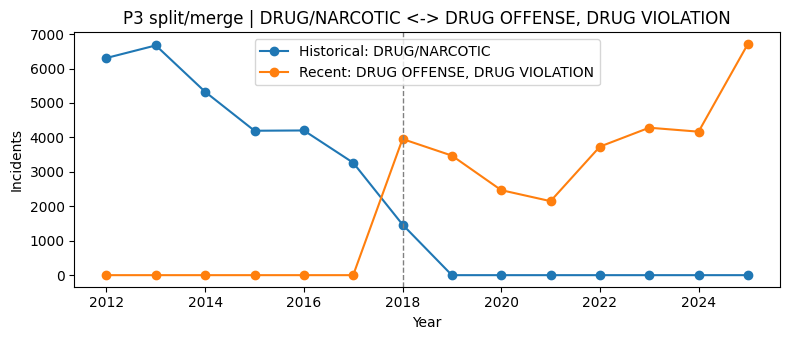

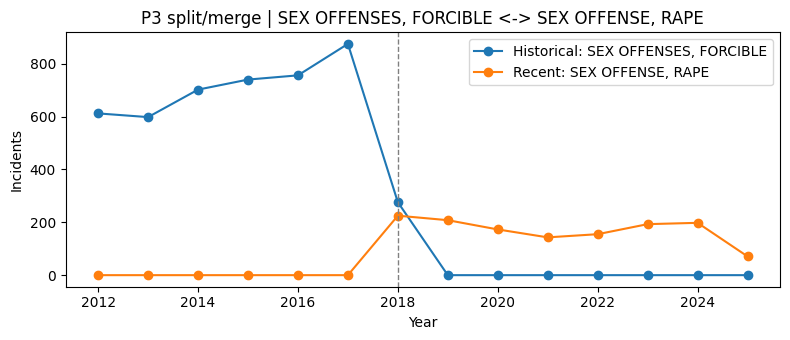

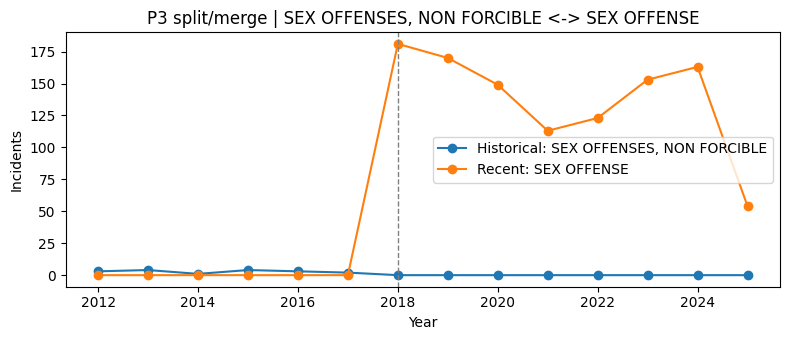

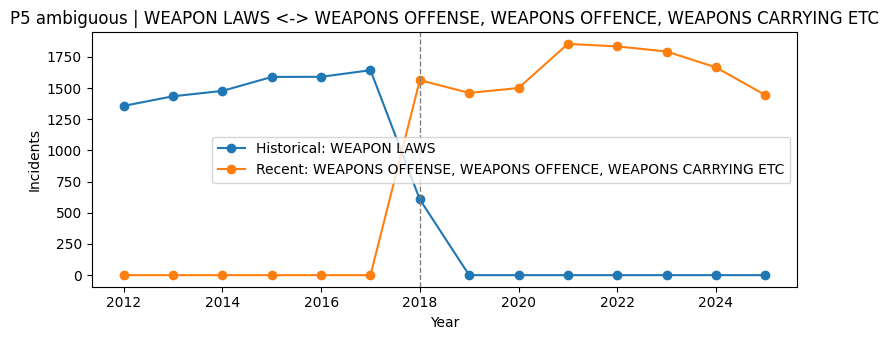

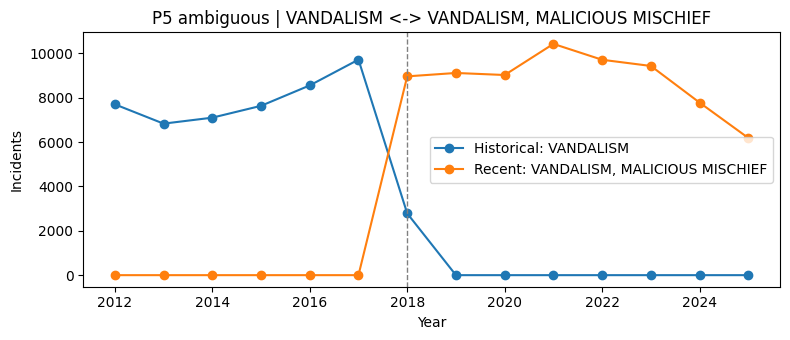

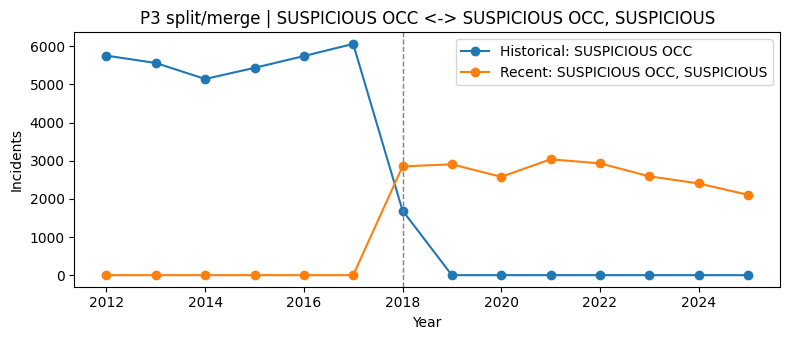

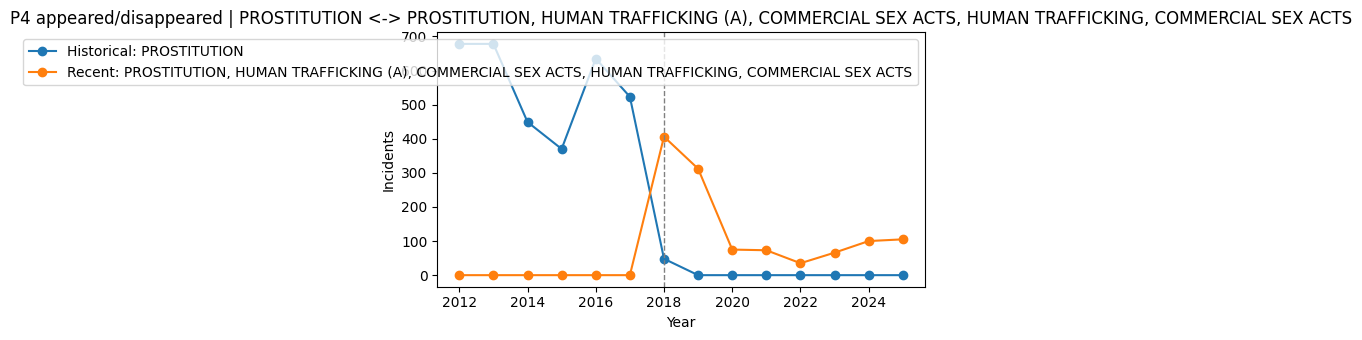

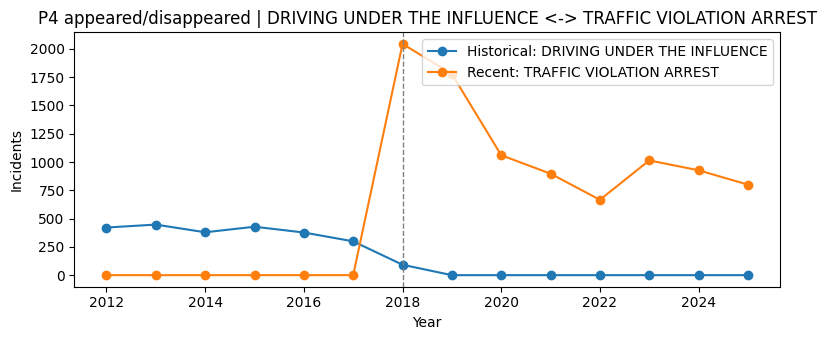

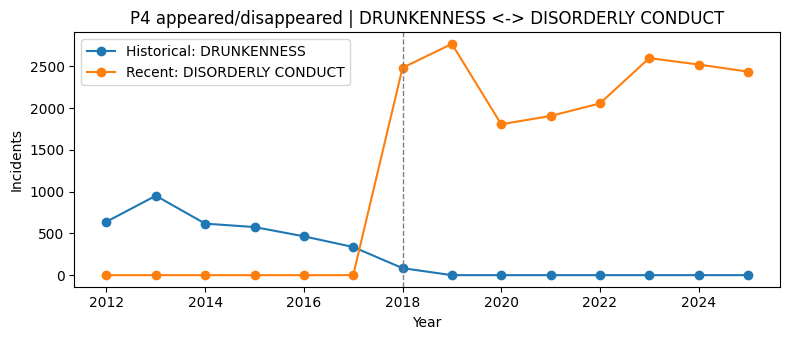

problem_tag          historical_category  \
2           P3 split/merge   SEX OFFENSES, NON FORCIBLE   
8  P4 appeared/disappeared                  DRUNKENNESS   
7  P4 appeared/disappeared  DRIVING UNDER THE INFLUENCE   
4             P5 ambiguous                    VANDALISM   
3             P5 ambiguous                  WEAPON LAWS   
0           P3 split/merge                DRUG/NARCOTIC   
5           P3 split/merge               SUSPICIOUS OCC   
6  P4 appeared/disappeared                 PROSTITUTION   
1           P3 split/merge       SEX OFFENSES, FORCIBLE   

                                   recent_categories  hist_mean_2015_2017  \
2                                        SEX OFFENSE             3.000000   
8                                 DISORDERLY CONDUCT           459.333333   
7                           TRAFFIC VIOLATION ARREST           368.000000   
4                      VANDALISM, MALICIOUS MISCHIEF          8637.333333   
3  WEAPONS OFFENSE, WEAPONS OFFENCE, WEAPONS CARR...          1608.333333   
0                       DRUG OFFENSE, DRUG VIOLATION          3887.000000   
5                         SUSPICIOUS OCC, SUSPICIOUS          5747.333333   
6  PROSTITUTION, HUMAN TRAFFICKING (A), COMMERCIA...           509.333333   
1                                  SEX OFFENSE, RAPE           790.333333   

   recent_mean_2019_2021  ratio_recent_over_hist  
2             144.000000               48.000000  
8            2160.666667                4.703919  
7            1245.000000                3.383152  
4            9524.333333                1.102694  
3            1606.000000                0.998549  
0            2696.666667                0.693766  
5            2840.000000                0.494142  
6             153.333333                0.301047  
1             174.666667                0.221004

In [61]:
# Step 2.4
# Purpose: run validation for all doubtful mappings and collect comparable evidence.

evidence_rows = []

for hist_cat, recent_cats, tag in candidates:
    result = validate_mapping(hist_cat, recent_cats, tag)
    evidence_rows.append(result)

evidence_24 = pd.DataFrame(evidence_rows).sort_values(
    by="ratio_recent_over_hist",
    ascending=False,
    na_position="last"
)

evidence_24


### Step 2.4 - Data-driven validation of ambiguous category mappings

To validate ambiguous mappings, we compared yearly incident counts for each candidate pair/group and inspected continuity around the 2018 transition.

Key conclusions from the validation:

- **Accepted (kept)**
  - `DRUG/NARCOTIC` -> `DRUG OFFENSE`, `DRUG VIOLATION`  
    This behaves like a plausible split/merge. The trend and scale are reasonably consistent across the transition.
  - `WEAPON LAWS` -> `WEAPONS OFFENSE`, `WEAPONS OFFENCE`, `WEAPONS CARRYING ETC`  
    Very strong continuity in yearly counts.
  - `VANDALISM` -> `VANDALISM`, `MALICIOUS MISCHIEF`  
    Reasonable continuity and plausible semantic overlap.
  - `SUSPICIOUS OCC` -> `SUSPICIOUS OCC`, `SUSPICIOUS`  
    Kept with lower confidence. This class is broad and likely sensitive to reporting practice changes.

- **Rejected (not kept)**
  - `SEX OFFENSES, NON FORCIBLE` -> `SEX OFFENSE`  
    Historical baseline is too small; ratio is unstable and not reliable.
  - `SEX OFFENSES, FORCIBLE` -> `SEX OFFENSE`, `RAPE`  
    Weak continuity; likely classification changes prevent a robust one-to-one merge.
  - `DRIVING UNDER THE INFLUENCE` -> `TRAFFIC VIOLATION ARREST`  
    Too broad on the recent side; likely over-inclusive.
  - `DRUNKENNESS` -> `DISORDERLY CONDUCT`  
    Too broad and conceptually mismatched.
  - `PROSTITUTION` + trafficking categories (extended mapping)  
    Adding trafficking-commercial-sex categories did not recover continuity.  
    Final choice is stricter: map prostitution only to prostitution.

Additional interpretation:
- Human trafficking categories are kept separate in the strict mapping because they do not provide a robust, defensible historical equivalence.
- Several low-confidence categories are highly policy/reporting dependent, so strict mappings are preferred for downstream analysis quality.
python



In [62]:
# Final ambiguous mappings kept after Step 2.4 validation
# (removed the candidates that were rejected)

final_ambiguous_matches = {
    "DRUG/NARCOTIC": ["DRUG OFFENSE", "DRUG VIOLATION"],
    "WEAPON LAWS": ["WEAPONS OFFENSE", "WEAPONS OFFENCE", "WEAPONS CARRYING ETC"],
    "VANDALISM": ["VANDALISM", "MALICIOUS MISCHIEF"],
    "SUSPICIOUS OCC": ["SUSPICIOUS OCC", "SUSPICIOUS"],
    "PROSTITUTION": ["PROSTITUTION"],  # accepted with medium confidence
}

final_ambiguous_df = pd.DataFrame(
    [(k, ", ".join(v)) for k, v in final_ambiguous_matches.items()],
    columns=["historical_category", "recent_categories_kept"]
)

final_ambiguous_df

historical_category                             recent_categories_kept
0       DRUG/NARCOTIC                       DRUG OFFENSE, DRUG VIOLATION
1         WEAPON LAWS  WEAPONS OFFENSE, WEAPONS OFFENCE, WEAPONS CARR...
2           VANDALISM                      VANDALISM, MALICIOUS MISCHIEF
3      SUSPICIOUS OCC                         SUSPICIOUS OCC, SUSPICIOUS
4        PROSTITUTION                                       PROSTITUTION

### Step 2.5: Define your Personal Focus Crimes

Given all these complications, it's time to make some decisions. You need to define a set of **Personal Focus Crimes** — categories that you can confidently track across both datasets.

> **Exercise 2.2**: Define Personal Focus Crimes
>
> Create a list of crime categories that:
> 1. Exist in both datasets (possibly with different names)
> 2. Have a mapping between the two naming systems that you trust based on checking trendlines
> 3. Are interesting enough to analyze (not too rare, not just "Other")
>
> For each Personal Focus Crime, document:
> - The name you'll use in your merged dataset
> - The corresponding category name in the historical data
> - The corresponding category name(s) in the recent data
> - Your confidence level (high/medium/low) in the mapping
> - Any notes or caveats
>
> **Example format:**
>
> | Personal Focus Crime | Historical | Recent | Confidence | Notes |
> |---------------------|------------|--------|------------|-------|
> | Assault | ASSAULT | Assault | High | Direct match |
> | Burglary | BURGLARY | Burglary | High | Direct match |
> | Drug Offense | DRUG/NARCOTIC | Drug Offense, Drug Violation | Medium | Merged two recent categories |
> | Vehicle Theft | VEHICLE THEFT | Motor Vehicle Theft | High | Name change only |
> | ... | ... | ... | ... | ... |
>
> It's completely fine if your Personal Focus Crimes list is shorter than our original focus crimes list. **Quality over quantity** — it's better to have 8 crimes you can track confidently than 16 where half are questionable.

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> Use your LLM to help identify good candidates and spot potential issues, but <b>you</b> need to make the final decisions about what goes on your list. These are judgment calls that affect all your downstream analysis.
</div>

In [63]:
# Step 2.5 - Personal Focus Crimes table
# Format required by exercise:
# Personal Focus Crime | Historical | Recent | Confidence | Notes

import pandas as pd

# 1) Clear direct matches (high confidence)
direct_rows = [
    ("Arson", "ARSON", ["ARSON"], "High", "Direct match"),
    ("Assault", "ASSAULT", ["ASSAULT"], "High", "Direct match"),
    ("Burglary", "BURGLARY", ["BURGLARY"], "High", "Direct match"),
    ("Disorderly Conduct", "DISORDERLY CONDUCT", ["DISORDERLY CONDUCT"], "High", "Direct match"),
    ("Embezzlement", "EMBEZZLEMENT", ["EMBEZZLEMENT"], "High", "Direct match"),
    ("Fraud", "FRAUD", ["FRAUD"], "High", "Direct match"),
    ("Gambling", "GAMBLING", ["GAMBLING"], "High", "Direct match"),
    ("Liquor Laws", "LIQUOR LAWS", ["LIQUOR LAWS"], "High", "Direct match"),
    ("Missing Person", "MISSING PERSON", ["MISSING PERSON"], "High", "Direct match"),
    ("Non-Criminal", "NON-CRIMINAL", ["NON-CRIMINAL"], "High", "Direct match"),
    ("Other Offenses", "OTHER OFFENSES", ["OTHER OFFENSES"], "High", "Direct match"),
    ("Prostitution", "PROSTITUTION", ["PROSTITUTION"], "Medium", "Kept strict after Step 2.4 validation"),
    ("Recovered Vehicle", "RECOVERED VEHICLE", ["RECOVERED VEHICLE"], "Medium", "Direct match"),
    ("Robbery", "ROBBERY", ["ROBBERY"], "High", "Direct match"),
    ("Stolen Property", "STOLEN PROPERTY", ["STOLEN PROPERTY"], "High", "Direct match"),
    ("Suicide", "SUICIDE", ["SUICIDE"], "High", "Direct match"),
]

# 2) Accepted ambiguous/split-merge matches
ambiguous_rows = [
    ("Drug Offense", "DRUG/NARCOTIC", ["DRUG OFFENSE", "DRUG VIOLATION"], "Medium", "Split/merge mapping accepted"),
    ("Forgery/Counterfeiting", "FORGERY/COUNTERFEITING", ["FORGERY AND COUNTERFEITING"], "High", "Name change"),
    ("Larceny/Theft", "LARCENY/THEFT", ["LARCENY THEFT"], "High", "Name change"),
    ("Suspicious Occurrence", "SUSPICIOUS OCC", ["SUSPICIOUS OCC", "SUSPICIOUS"], "Low-Medium", "Broad class; sensitive to reporting practice"),
    ("Vandalism", "VANDALISM", ["VANDALISM", "MALICIOUS MISCHIEF"], "Medium", "Ambiguous but trend continuity acceptable"),
    ("Vehicle Theft", "VEHICLE THEFT", ["MOTOR VEHICLE THEFT", "MOTOR VEHICLE THEFT?"], "High", "Name change"),
    ("Warrants", "WARRANTS", ["WARRANT"], "High", "Name change"),
    ("Weapon Laws", "WEAPON LAWS", ["WEAPONS OFFENSE", "WEAPONS OFFENCE", "WEAPONS CARRYING ETC"], "High", "Strong continuity"),
]

# 3) Optional rejected/very-low mappings (for documentation, not focus analysis)
include_very_low = True
very_low_rows = [
    ("Sex Offenses (Forcible)", "SEX OFFENSES, FORCIBLE", ["SEX OFFENSE", "RAPE"], "Very Low", "Rejected for primary analysis; weak continuity"),
    ("Sex Offenses (Non Forcible)", "SEX OFFENSES, NON FORCIBLE", ["SEX OFFENSE"], "Very Low", "Rejected; unstable tiny historical base"),
    ("Driving Under Influence", "DRIVING UNDER THE INFLUENCE", ["TRAFFIC VIOLATION ARREST"], "Very Low", "Rejected; recent category too broad"),
    ("Drunkenness", "DRUNKENNESS", ["DISORDERLY CONDUCT"], "Very Low", "Rejected; conceptual mismatch"),
   ]

rows = direct_rows + ambiguous_rows + (very_low_rows if include_very_low else [])

focus_df = pd.DataFrame(rows, columns=[
    "Personal Focus Crime", "Historical", "Recent", "Confidence", "Notes"
])

focus_df["Recent"] = focus_df["Recent"].apply(lambda x: ", ".join(x))
focus_df


Personal Focus Crime                   Historical  \
0                         Arson                        ARSON   
1                       Assault                      ASSAULT   
2                      Burglary                     BURGLARY   
3            Disorderly Conduct           DISORDERLY CONDUCT   
4                  Embezzlement                 EMBEZZLEMENT   
5                         Fraud                        FRAUD   
6                      Gambling                     GAMBLING   
7                   Liquor Laws                  LIQUOR LAWS   
8                Missing Person               MISSING PERSON   
9                  Non-Criminal                 NON-CRIMINAL   
10               Other Offenses               OTHER OFFENSES   
11                 Prostitution                 PROSTITUTION   
12            Recovered Vehicle            RECOVERED VEHICLE   
13                      Robbery                      ROBBERY   
14              Stolen Property              STOLEN PROPERTY   
15                      Suicide                      SUICIDE   
16                 Drug Offense                DRUG/NARCOTIC   
17       Forgery/Counterfeiting       FORGERY/COUNTERFEITING   
18                Larceny/Theft                LARCENY/THEFT   
19        Suspicious Occurrence               SUSPICIOUS OCC   
20                    Vandalism                    VANDALISM   
21                Vehicle Theft                VEHICLE THEFT   
22                     Warrants                     WARRANTS   
23                  Weapon Laws                  WEAPON LAWS   
24      Sex Offenses (Forcible)       SEX OFFENSES, FORCIBLE   
25  Sex Offenses (Non Forcible)   SEX OFFENSES, NON FORCIBLE   
26      Driving Under Influence  DRIVING UNDER THE INFLUENCE   
27                  Drunkenness                  DRUNKENNESS   

                                               Recent  Confidence  \
0                                               ARSON        High   
1                                             ASSAULT        High   
2                                            BURGLARY        High   
3                                  DISORDERLY CONDUCT        High   
4                                        EMBEZZLEMENT        High   
5                                               FRAUD        High   
6                                            GAMBLING        High   
7                                         LIQUOR LAWS        High   
8                                      MISSING PERSON        High   
9                                        NON-CRIMINAL        High   
10                                     OTHER OFFENSES        High   
11                                       PROSTITUTION      Medium   
12                                  RECOVERED VEHICLE      Medium   
13                                            ROBBERY        High   
14                                    STOLEN PROPERTY        High   
15                                            SUICIDE        High   
16                       DRUG OFFENSE, DRUG VIOLATION      Medium   
17                         FORGERY AND COUNTERFEITING        High   
18                                      LARCENY THEFT        High   
19                         SUSPICIOUS OCC, SUSPICIOUS  Low-Medium   
20                      VANDALISM, MALICIOUS MISCHIEF      Medium   
21          MOTOR VEHICLE THEFT, MOTOR VEHICLE THEFT?        High   
22                                            WARRANT        High   
23  WEAPONS OFFENSE, WEAPONS OFFENCE, WEAPONS CARR...        High   
24                                  SEX OFFENSE, RAPE    Very Low   
25                                        SEX OFFENSE    Very Low   
26                           TRAFFIC VIOLATION ARREST    Very Low   
27                                 DISORDERLY CONDUCT    Very Low   

                                             Notes  
0                                     Direct match  
1                                     Direct m

### Step 2.6: Merge and validate

> **Exercise 2.3**: Now you're ready to construct your final dataset and put the pieces from above together! Some of the key elements are:
>
> * Standardize column names across both datasets
> * Apply your category mappings to create a unified category column
> * Concatenate the two datasets
> * Remove any duplicate records (there may be overlap around May 2018 — check for incidents that appear in both files)
> * **Save your merged dataset for use in future analyses**

In [64]:
# Step 2.6 - Concatenation strategy (safe with your overlap diagnostics)

# Strategy used:
# 1) Keep only High/Medium mappings from focus_df
# 2) Create unified label 'personal_focus_crime' in BOTH datasets
# 3) Concatenate historical + recent
# 4) Deduplicate with STRICT key (not incident_id-only), because incident_id repeats across categories

import pandas as pd

# Ensure normalized category exists
if "cat_norm" not in hist_aligned.columns:
    hist_aligned["cat_norm"] = hist_aligned["incident_category"].astype(str).str.strip().str.upper()
if "cat_norm" not in recent_aligned.columns:
    recent_aligned["cat_norm"] = recent_aligned["incident_category"].astype(str).str.strip().str.upper()

# 1) Keep only High/Medium
focus_keep = focus_df[focus_df["Confidence"].str.upper().isin(["HIGH", "MEDIUM"])].copy()

# 2) Build mapping dicts
hist_map = {
    str(r["Historical"]).strip().upper(): str(r["Personal Focus Crime"]).strip().upper()
    for _, r in focus_keep.iterrows()
}

recent_map = {}
for _, r in focus_keep.iterrows():
    unified = str(r["Personal Focus Crime"]).strip().upper()
    rec_list = [x.strip().upper() for x in str(r["Recent"]).split(",")]
    for c in rec_list:
        recent_map[c] = unified

# Apply mapping
hist_focus = hist_aligned.copy()
recent_focus = recent_aligned.copy()

hist_focus["personal_focus_crime"] = hist_focus["cat_norm"].map(hist_map)
recent_focus["personal_focus_crime"] = recent_focus["cat_norm"].map(recent_map)

hist_focus = hist_focus[hist_focus["personal_focus_crime"].notna()].copy()
recent_focus = recent_focus[recent_focus["personal_focus_crime"].notna()].copy()

hist_focus["source"] = "historical"
recent_focus["source"] = "recent"

In [65]:
# Build normalized keys for cross-dataset comparison
h = hist_focus.copy()
r = recent_focus.copy()

h["dt_key"] = pd.to_datetime(h["incident_datetime"], errors="coerce").dt.floor("min")
r["dt_key"] = pd.to_datetime(r["incident_datetime"], errors="coerce").dt.floor("min")

h["crime_key"] = h["personal_focus_crime"].astype(str).str.strip().str.upper()
r["crime_key"] = r["personal_focus_crime"].astype(str).str.strip().str.upper()

h["district_key"] = h["police_district"].astype(str).str.strip().str.upper()
r["district_key"] = r["police_district"].astype(str).str.strip().str.upper()

dup_keys = ["dt_key", "crime_key", "district_key"]

# Count cross-dataset duplicate candidates
h_keys = h[dup_keys].dropna().drop_duplicates()
r_keys = r[dup_keys].dropna().drop_duplicates()
cross_dup_key_count = len(h_keys.merge(r_keys, on=dup_keys, how="inner"))

# Remove ONLY recent rows that match historical keys on the selected rule
r_marked = r.merge(h_keys, on=dup_keys, how="left", indicator=True)
recent_focus_noxdup = r_marked[r_marked["_merge"] == "left_only"].drop(columns=["_merge"])

# Final merged dataset (no within-dataset dedup)
merged_focus_final = pd.concat([h, recent_focus_noxdup], ignore_index=True)

print("Cross-dataset duplicate keys (rule dt+crime+district):", cross_dup_key_count)
print("Historical rows kept:", len(h))
print("Recent rows before cross-dataset filter:", len(r))
print("Recent rows removed by cross-dataset rule:", len(r) - len(recent_focus_noxdup))
print("Final merged rows:", len(merged_focus_final))

Cross-dataset duplicate keys (rule dt+crime+district): 22986
Historical rows kept: 1917671
Recent rows before cross-dataset filter: 820399
Recent rows removed by cross-dataset rule: 26641
Final merged rows: 2711429


> **Mini Exercise**: Quick visual overview to validate your merge
>
> Create a set of line plots showing yearly counts for each of your Personal Focus Crimes from 2003-2025 (or whatever your date range is).
>
> * Does 2018 look reasonable? The transition between datasets should be make sense
> * For any suspicious patterns, document what you found and how you addressed it (or why you left it as-is)

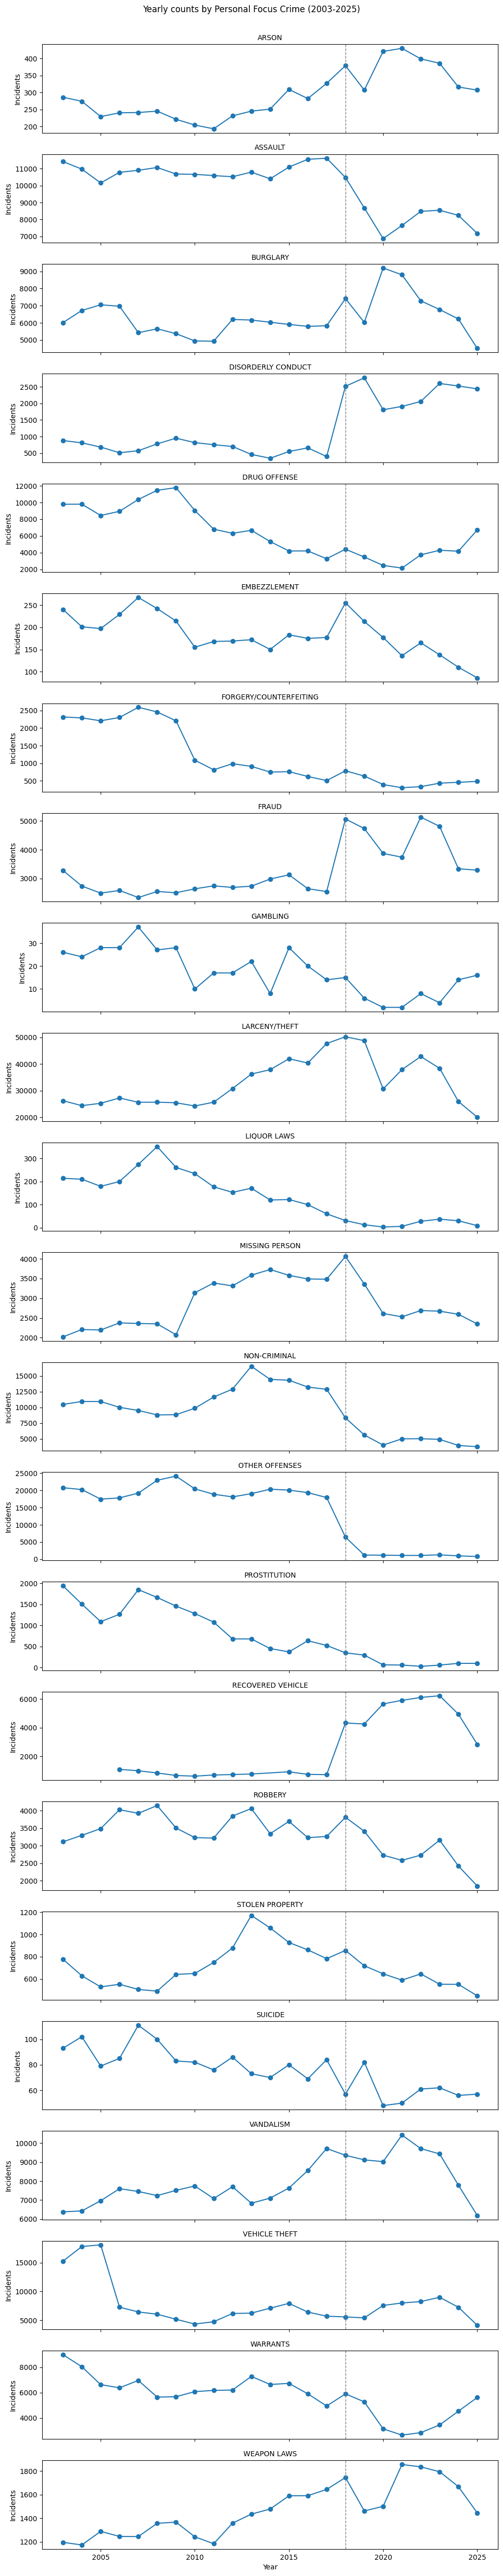

In [66]:
# Mini Exercise - Quick visual overview to validate merge
# Uses merged_focus_final from Step 2.6

import matplotlib.pyplot as plt

# Minimal plotting from merged_focus_final using existing incident_year
yearly = (
    merged_focus_final.loc[merged_focus_final["incident_year"].between(2003, 2025)]
    .groupby(["personal_focus_crime", "incident_year"])
    .size()
    .rename("n")
    .reset_index()
)

crimes = sorted(yearly["personal_focus_crime"].unique())
n = len(crimes)

fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(10, 2.2*n), sharex=True)
if n == 1:
    axes = [axes]

for ax, crime in zip(axes, crimes):
    d = yearly[yearly["personal_focus_crime"] == crime]
    ax.plot(d["incident_year"], d["n"], marker="o", linewidth=1.5)
    ax.axvline(2018, linestyle="--", linewidth=1, color="gray")
    ax.set_title(crime, fontsize=10)
    ax.set_ylabel("Incidents")

axes[-1].set_xlabel("Year")
fig.suptitle("Yearly counts by Personal Focus Crime (2003-2025)", y=1.002)
plt.tight_layout()
plt.show()



In [67]:
## From the visual plots above and although this next categories have the same name across both datasets, 
# we will not include them in the final merged dataset because they do not have a clear personal focus and are more 
# likely to be affected by reporting practice changes (e.g. reclassification of certain incidents as non-criminal or other offenses):

to_exclude = ["OTHER OFFENSES", "DISORDERLY CONDUCT", "NON-CRIMINAL"]

merged_focus_final = merged_focus_final[
    ~merged_focus_final["personal_focus_crime"].isin(to_exclude)
].copy()

In [68]:
# Optional helper table to flag suspicious 2018 transitions automatically

y17 = yearly[yearly["incident_year"] == 2017].set_index("personal_focus_crime")["n"]
y18 = yearly[yearly["incident_year"] == 2018].set_index("personal_focus_crime")["n"]
y19 = yearly[yearly["incident_year"] == 2019].set_index("personal_focus_crime")["n"]

transition = pd.concat([y17.rename("y2017"), y18.rename("y2018"), y19.rename("y2019")], axis=1).fillna(0)
transition["ratio_2018_2017"] = transition["y2018"] / transition["y2017"].replace(0, pd.NA)
transition["ratio_2019_2018"] = transition["y2019"] / transition["y2018"].replace(0, pd.NA)

# Simple suspicious rule: big jump/drop around transition
transition["suspicious"] = (
    (transition["ratio_2018_2017"] > 2) | (transition["ratio_2018_2017"] < 0.5) |
    (transition["ratio_2019_2018"] > 2) | (transition["ratio_2019_2018"] < 0.5)
)

transition.sort_values(["suspicious", "ratio_2018_2017"], ascending=[False, False])


y2017  y2018  y2019  ratio_2018_2017  ratio_2019_2018  \
personal_focus_crime                                                            
DISORDERLY CONDUCT        395   2515   2769         6.367089         1.100994   
RECOVERED VEHICLE         715   4328   4249         6.053147         0.981747   
GAMBLING                   14     15      6         1.071429         0.400000   
LIQUOR LAWS                60     31     13         0.516667         0.419355   
OTHER OFFENSES          17890   6395   1195         0.357462         0.186865   
FRAUD                    2542   5066   4734         1.992919         0.934465   
FORGERY/COUNTERFEITING    509    786    636         1.544204         0.809160   
EMBEZZLEMENT              177    255    213         1.440678         0.835294   
DRUG OFFENSE             3265   4406   3472         1.349464         0.788016   
BURGLARY                 5828   7412   6022         1.271791         0.812466   
WARRANTS                 4943   5898   5271         1.193203         0.893693   
ROBBERY                  3265   3814   3413         1.168147         0.894861   
MISSING PERSON           3482   4060   3360         1.165997         0.827586   
ARSON                     327    379    307         1.159021         0.810026   
STOLEN PROPERTY           782    856    718         1.094629         0.838785   
WEAPON LAWS              1644   1745   1462         1.061436         0.837822   
LARCENY/THEFT           47714  50240  48782         1.052940         0.970979   
VEHICLE THEFT            5705   5576   5411         0.977388         0.970409   
VANDALISM                9719   9361   9118         0.963165         0.974041   
ASSAULT                 11613  10475   8680         0.902006         0.828640   
SUICIDE                    84     57     82         0.678571         1.438596   
PROSTITUTION              523    348    293         0.665392         0.841954   
NON-CRIMINAL            12866   8320   5611         0.646666         0.674399   

                        suspicious  
personal_focus_crime                
DISORDERLY CONDUCT            True  
RECOVERED VEHICLE             True  
GAMBLING                      True  
LIQUOR LAWS                   True  
OTHER OFFENSES                True  
FRAUD                        False  
FORGERY/COUNTERFEITING       False  
EMBEZZLEMENT                 False  
DRUG OFFENSE                 False  
BURGLARY                     False  
WARRANTS                     False  
ROBBERY                      False  
MISSING PERSON               False  
ARSON                        False  
STOLEN PROPERTY              False  
WEAPON LAWS                  False  
LARCENY/THEFT                False  
VEHICLE THEFT                False  
VANDALISM                    False  
ASSAULT                      False  
SUICIDE                      False  
PROSTITUTION                 False  
NON-CRIMINAL                 False

### Step 2.7: Reflection on the merge process

> **Exercise 2.4**: Reflect on your work

**What assumptions did I have to make during this merge?**

- I assumed that normalized category names (`upper/strip`) are a valid baseline for comparison across datasets.
- I assumed that some category pairs are conceptual matches even when names differ (for example split/merge cases such as `DRUG/NARCOTIC` vs `DRUG OFFENSE` + `DRUG VIOLATION`).
- I assumed that cross-dataset duplicate detection should be based on a practical key (`incident_datetime` + unified crime category + normalized police district), because direct shared IDs were not reliable.
- I assumed that trend continuity around 2018 is a reasonable validation signal for mapping quality, while acknowledging that policy/reporting changes may also drive breaks.
- I assumed strict mapping is preferable to forced mapping when semantic uncertainty is high.

**Which Personal Focus Crimes am I most/least confident about? Why?**

- **Most confident**: direct or near-direct mappings with stable yearly behavior (for example `ASSAULT`, `BURGLARY`, `ROBBERY`, `RECOVERED VEHICLE`, and validated rename cases such as `LARCENY/THEFT` -> `LARCENY THEFT`).
- **Medium confidence**: split/merge or terminology-variant mappings where trends are plausible but not perfectly stable (for example `DRUG/NARCOTIC`, `VANDALISM`, `SUSPICIOUS OCC`).
- **Least confident**: categories with weak semantic equivalence or unstable trend ratios (for example some sex-offense mappings, `DRUNKENNESS`, and `DRIVING UNDER THE INFLUENCE`). These were either excluded from the primary mapping or kept only as sensitivity ideas.

**If someone used my merged dataset without reading my documentation, what mistakes might they make?**

- They might treat all mappings as equally reliable, ignoring confidence levels.
- They might over-interpret trend jumps around 2018 as real crime changes rather than category-definition/reporting changes.
- They might assume duplicate handling was exact at incident level, even though duplicate logic used a practical key and not a universal shared incident identifier.
- They might assume unmatched categories disappeared in reality, when in many cases they were reclassified.

**How does this connect to the "dirty data" concept from Richardson et al. (Week 1)?**

- This merge shows that “dirty data” is not only missing values or typos; it also includes shifting schemas, renamed categories, split/merged definitions, and ambiguous legal/administrative classifications.
- The cleaning and mapping decisions directly shape downstream conclusions. If these assumptions are hidden, analyses can look precise but be systematically misleading.
- In other words, data quality is deeply tied to institutional and historical context, not just technical preprocessing.


<div class="alert alert-block alert-info">
<b>LLM guidance:</b> The reflection should be your own thinking. This is where you practice the critical data science reasoning that separates good analysts from people who just run code.
</div>

**Uncle Sune Rants**: This run of exercises and mini exercises in part 2 migth feel frustrating and difficult. If yes, that's awesome! That's the point. You're getting stronger, smarter, and ready for the real world.

In the real world, you almost never get perfectly clean, perfectly formatted data handed to you on a silver platter. The ability to wrangle messy, inconsistent data into a usable form is one of the most valuable skills in data science. 

## Part 3: Visualizing patterns in the data

Visualizing data is a powerful technique that helps us exploit the human eye and make complex patterns easier to identify. 

Let's use our new mega dataset to look for interesting patterns in the big crime-data. Only consider your Personal Focus Crimes (see Exercise 2.2 above). We'll be generating lots of plots, remember to add good axes, use subplots, pack the plots closely, etc.

* **Hint**: You may use this exercise as an extra validation of the personal focus crimes, and I won't be mad if you go back to Exercise 2.2/2.3 and update your list after having done this exercise.

> **Exercise 3.1**: More temporal patterns
>
> Last time we plotted the development over time (how each of the focus crimes changed over time, year-by-year). Today we'll start by looking at the developments across the months, weekdays, and across the 24 hours of the day. 
>
> * *Yearly trends*. Redo the plots from last week with the new dataset. Do you see anything that surprises you?
> * *Weekly patterns*. Basically, we'll forget about the yearly variation and just count up what happens during each weekday (Monday, Tuesday, ...). 
> * *The months*. We can also check if some months are worse by counting up number of crimes in Jan, Feb, ..., Dec. Did you see any surprises there?
> * *The 24 hour cycle*. We can also forget about weekday and simply count up the number of each crime-type that occurs in the dataset from midnight to 1am, 1am - 2am ... and so on. Again: Give me a couple of comments on what you see. 
> * *Hours of the week*. But by looking at just 24 hours, we may be missing some important trends that can be modulated by week-day, so let's also check out the 168 hours of the week. So let's see the number of each crime-type Monday night from midnight to 1am, Monday night from 1am-2am - all the way to Sunday night from 11pm to midnight.
>    * What does this plot tell you about the limitations of your "24 hour cycle" plot from above.
>    * For some of the crime-types with lots of data, try taking your binning to the 5-minute level. What does that show you? 

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> It's OK to ask your LLM for help with creating these plots, <b>but try on your own first</b>. Use the LLM as a kind of TA to help you get your code to work. Don't just ask for answers and pre-written code. By actually doing the counting and slicing yourself, you'll start to get a feel for how to work with temporal data in pandas. That's a key part of becoming a data whisperer.
</div>

In [69]:
# Base temporal fields (minimal additions)
merged_focus_final["dt"] = pd.to_datetime(merged_focus_final["incident_datetime"], errors="coerce")
merged_focus_final = merged_focus_final[merged_focus_final["dt"].notna()].copy()

merged_focus_final["year"] = merged_focus_final["incident_year"]
merged_focus_final["month"] = merged_focus_final["dt"].dt.month
merged_focus_final["weekday"] = merged_focus_final["dt"].dt.dayofweek   # Mon=0
merged_focus_final["hour"] = merged_focus_final["dt"].dt.hour
merged_focus_final["hour_of_week"] = merged_focus_final["weekday"] * 24 + merged_focus_final["hour"]

In [70]:
# Week1-like plotting helper (4x4 grid style)
def plot_focus_grid(df, x_col, x_label, plot_kind="bar", x_order=None, title_prefix=""):
    crimes = sorted(df["personal_focus_crime"].dropna().unique())
    n = len(crimes)
    ncols = 4
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 3.8*nrows), sharex=False)
    axes = axes.flatten()

    for i, crime in enumerate(crimes):
        ax = axes[i]
        d = df[df["personal_focus_crime"] == crime]
        g = d.groupby(x_col).size()

        if x_order is not None:
            g = g.reindex(x_order, fill_value=0)
        else:
            g = g.sort_index()

        if plot_kind == "line":
            ax.plot(g.index, g.values, marker="o", linewidth=1.3)
        else:
            ax.bar(g.index, g.values)

        if x_col == "year":
            ax.axvline(2018, linestyle="--", linewidth=1, color="gray")

        ax.set_title(crime, fontsize=10)

    # hide empty panels
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(title_prefix, fontsize=18)
    fig.supxlabel(x_label, fontsize=14)
    fig.supylabel("Number of incidents", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


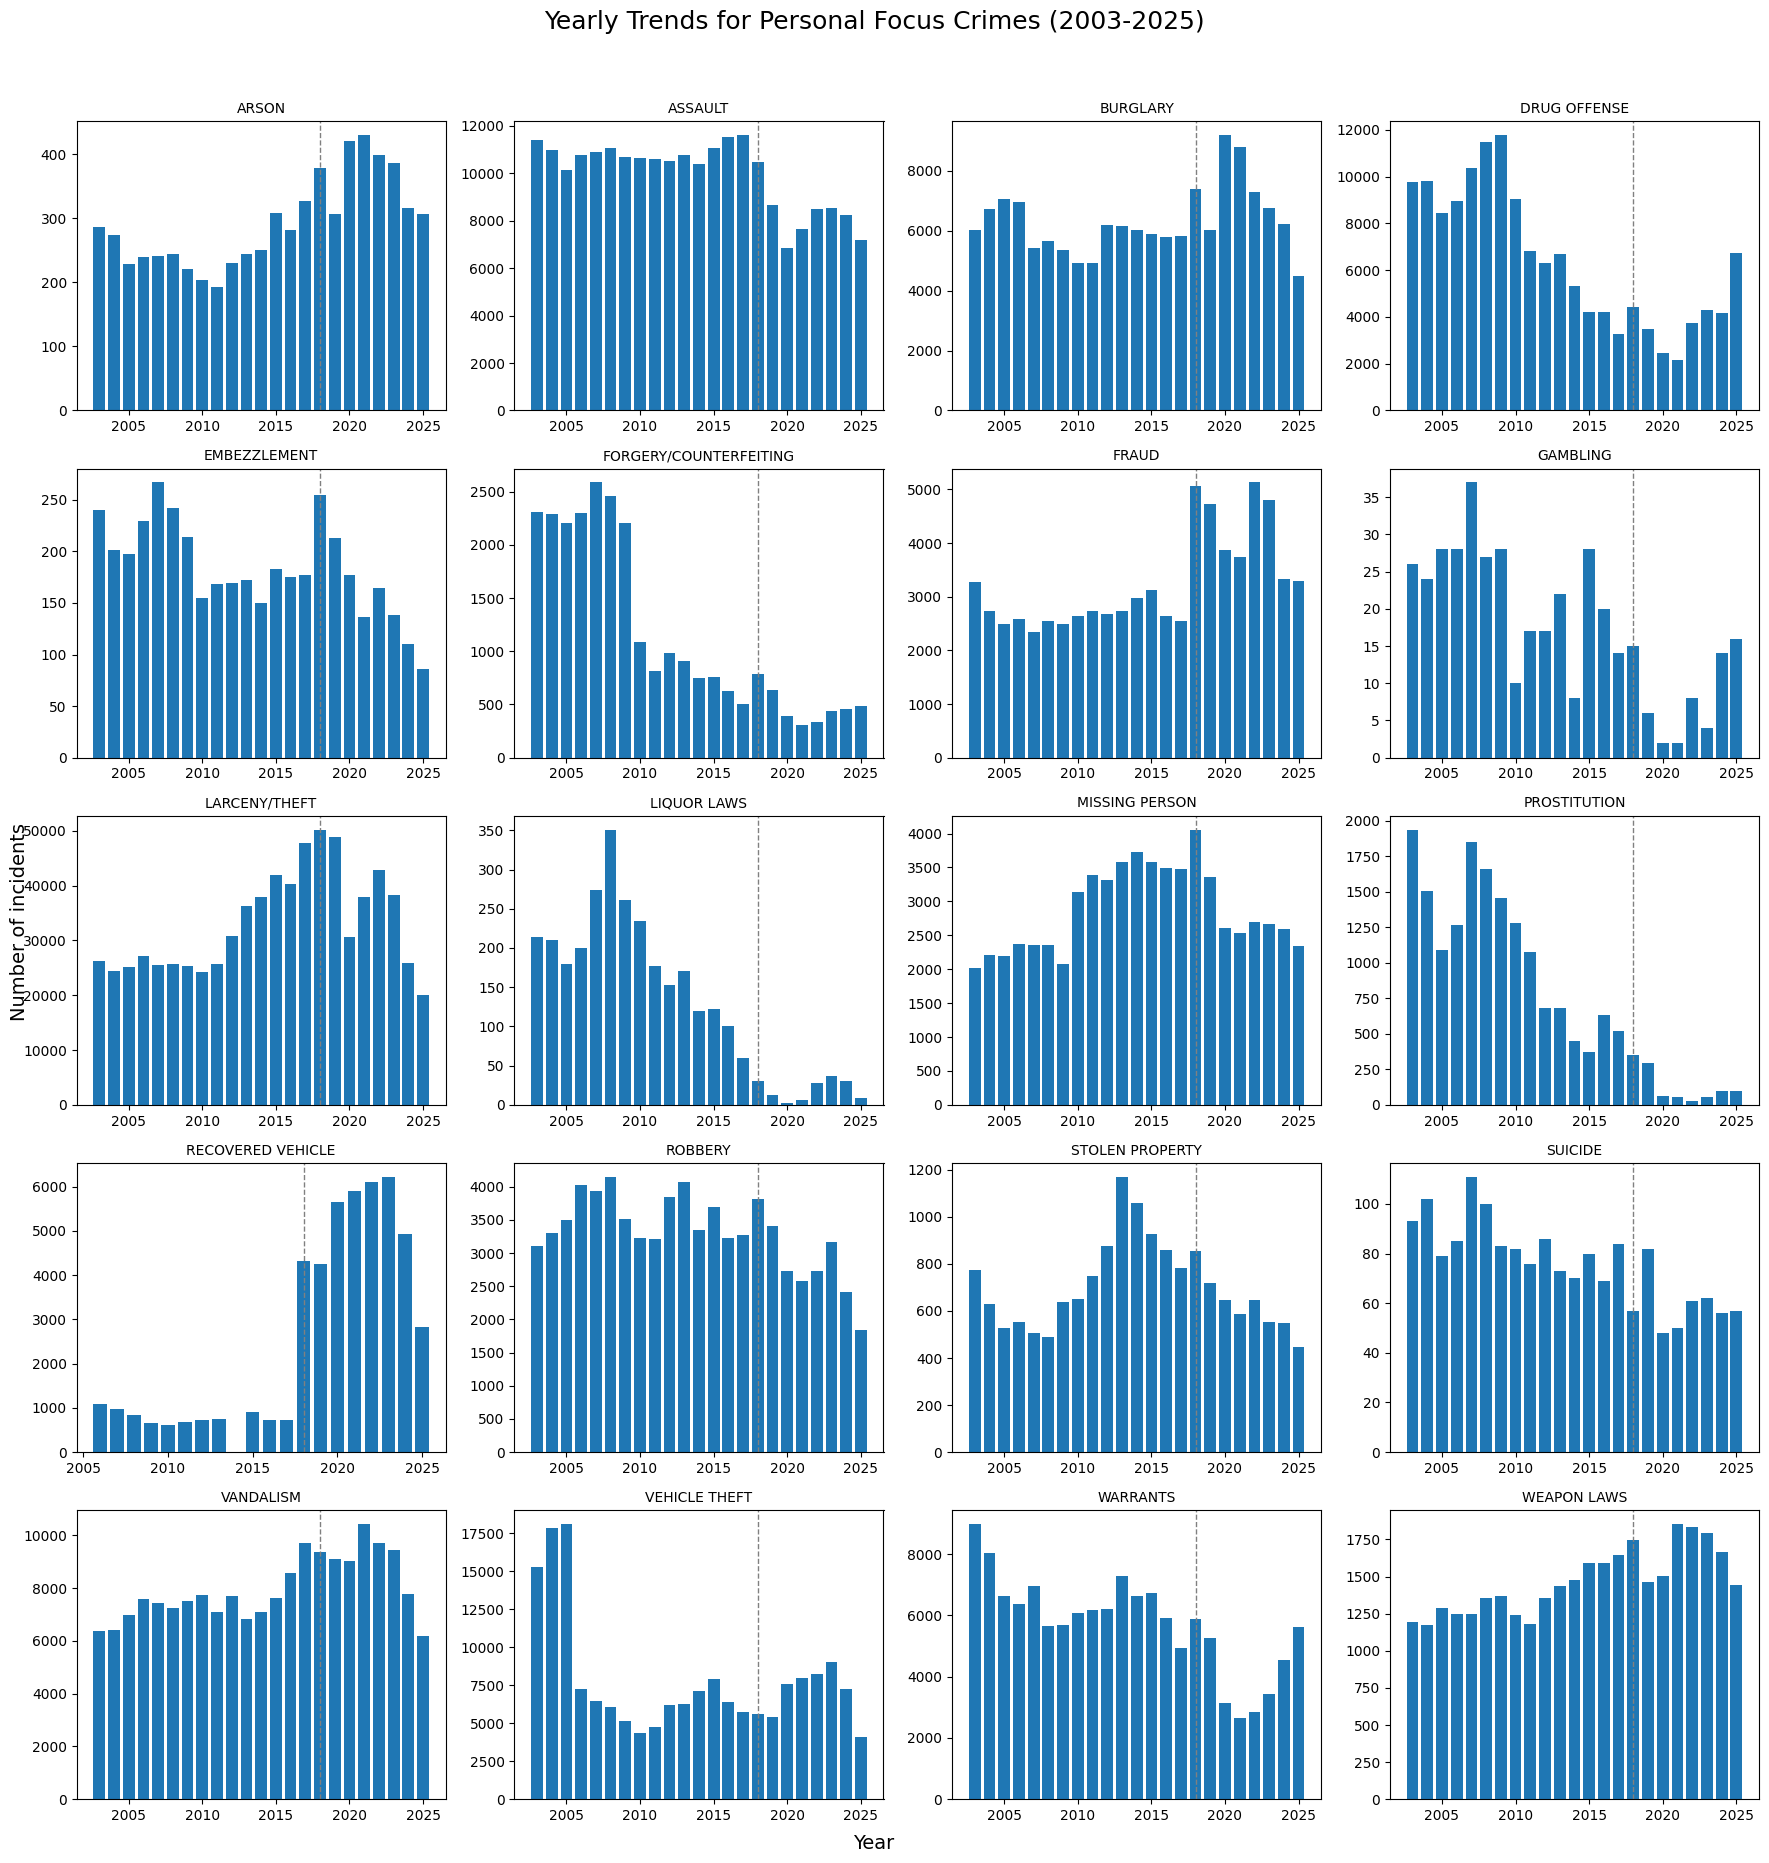

In [71]:
# 1) Yearly trends
plot_focus_grid(
    merged_focus_final[merged_focus_final["year"].between(2003, 2025)],
    x_col="year",
    x_label="Year",
    plot_kind="bar",
    title_prefix="Yearly Trends for Personal Focus Crimes (2003-2025)"
)

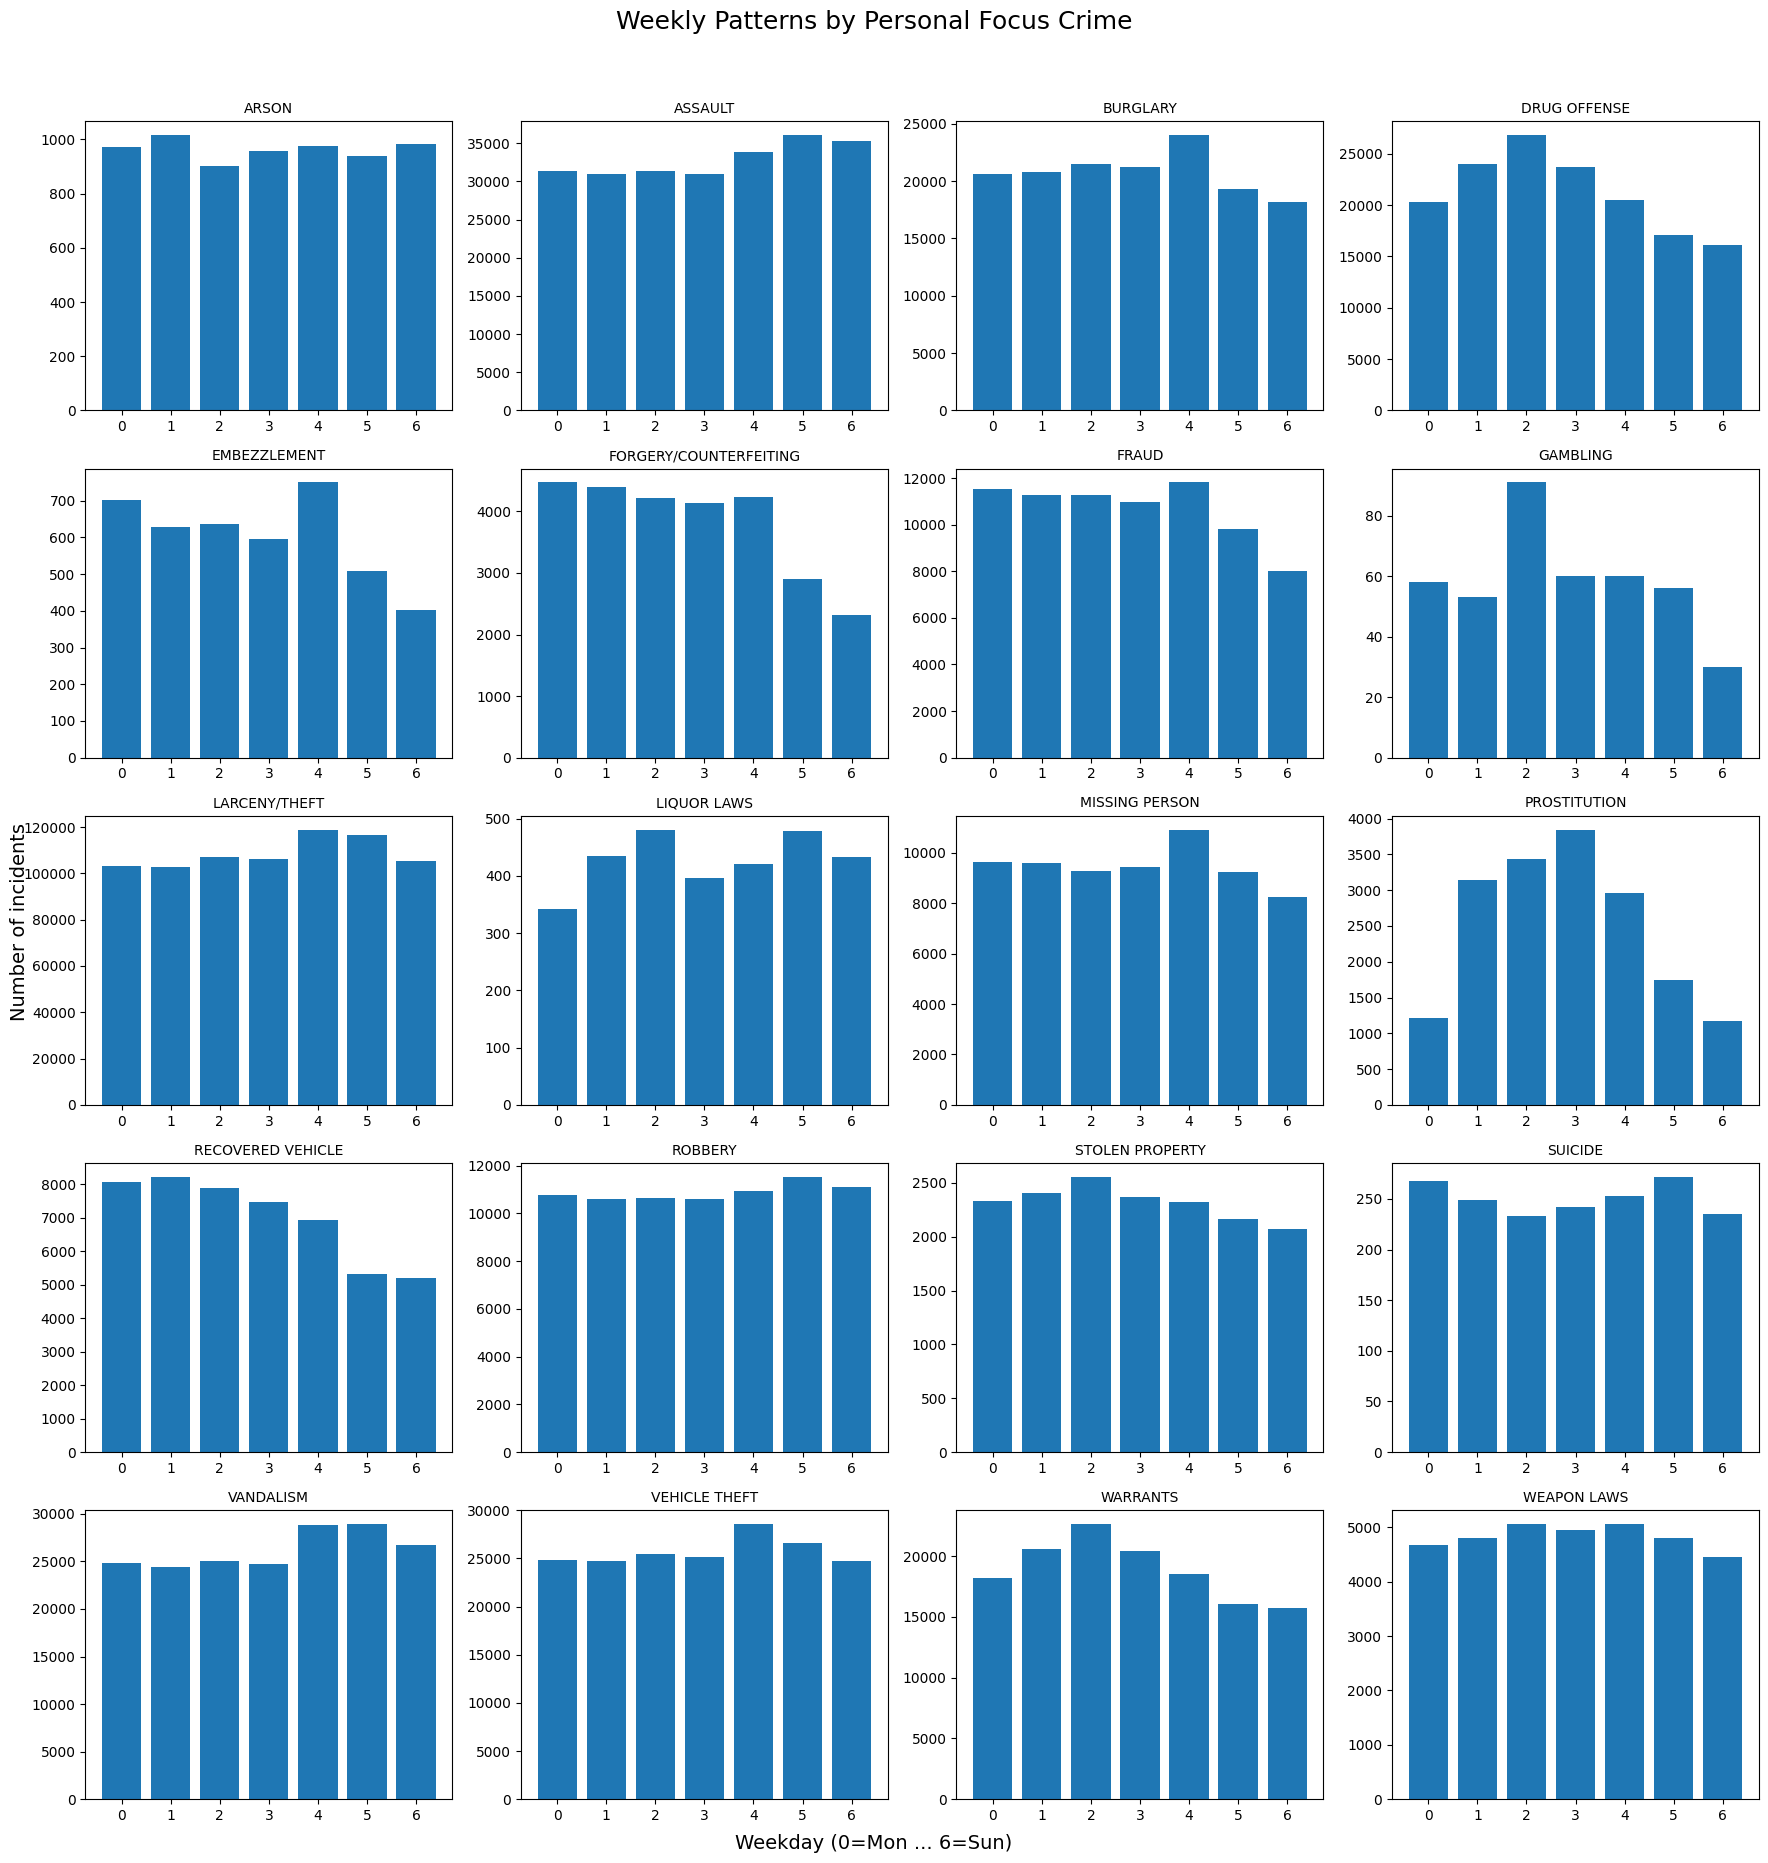

In [72]:
# 2) Weekly patterns
plot_focus_grid(
    merged_focus_final,
    x_col="weekday",
    x_label="Weekday (0=Mon ... 6=Sun)",
    plot_kind="bar",
    x_order=list(range(7)),
    title_prefix="Weekly Patterns by Personal Focus Crime"
)

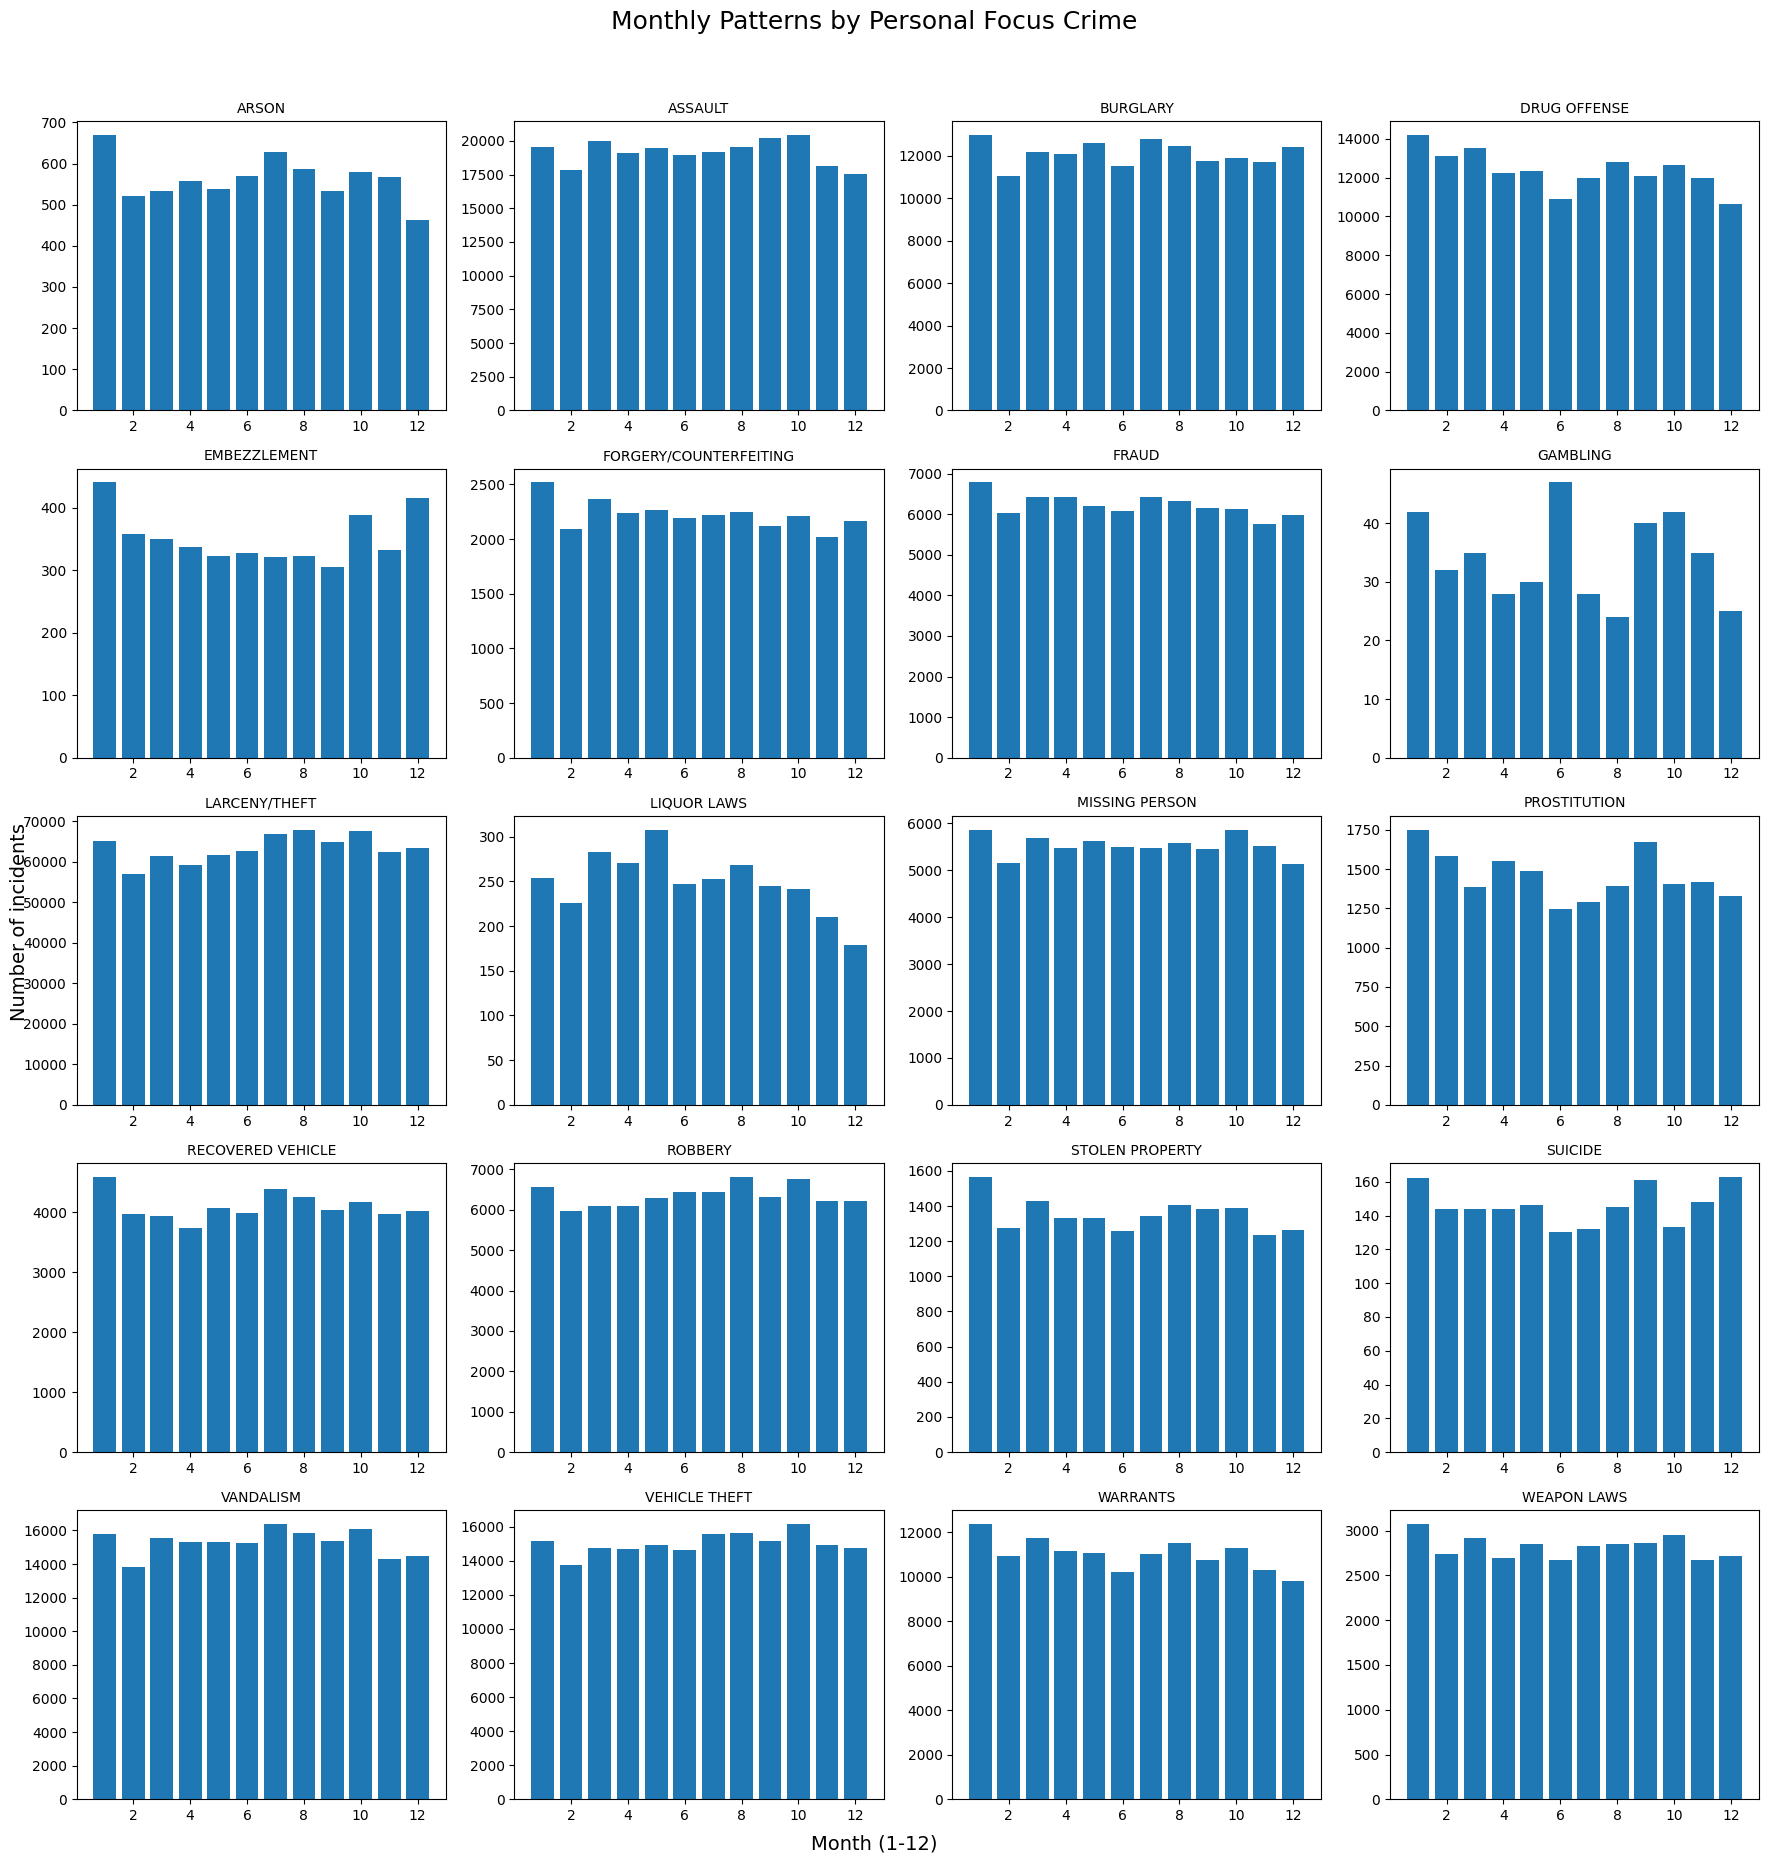

In [73]:
# 3) Monthly patterns
plot_focus_grid(
    merged_focus_final,
    x_col="month",
    x_label="Month (1-12)",
    plot_kind="bar",
    x_order=list(range(1, 13)),
    title_prefix="Monthly Patterns by Personal Focus Crime"
)

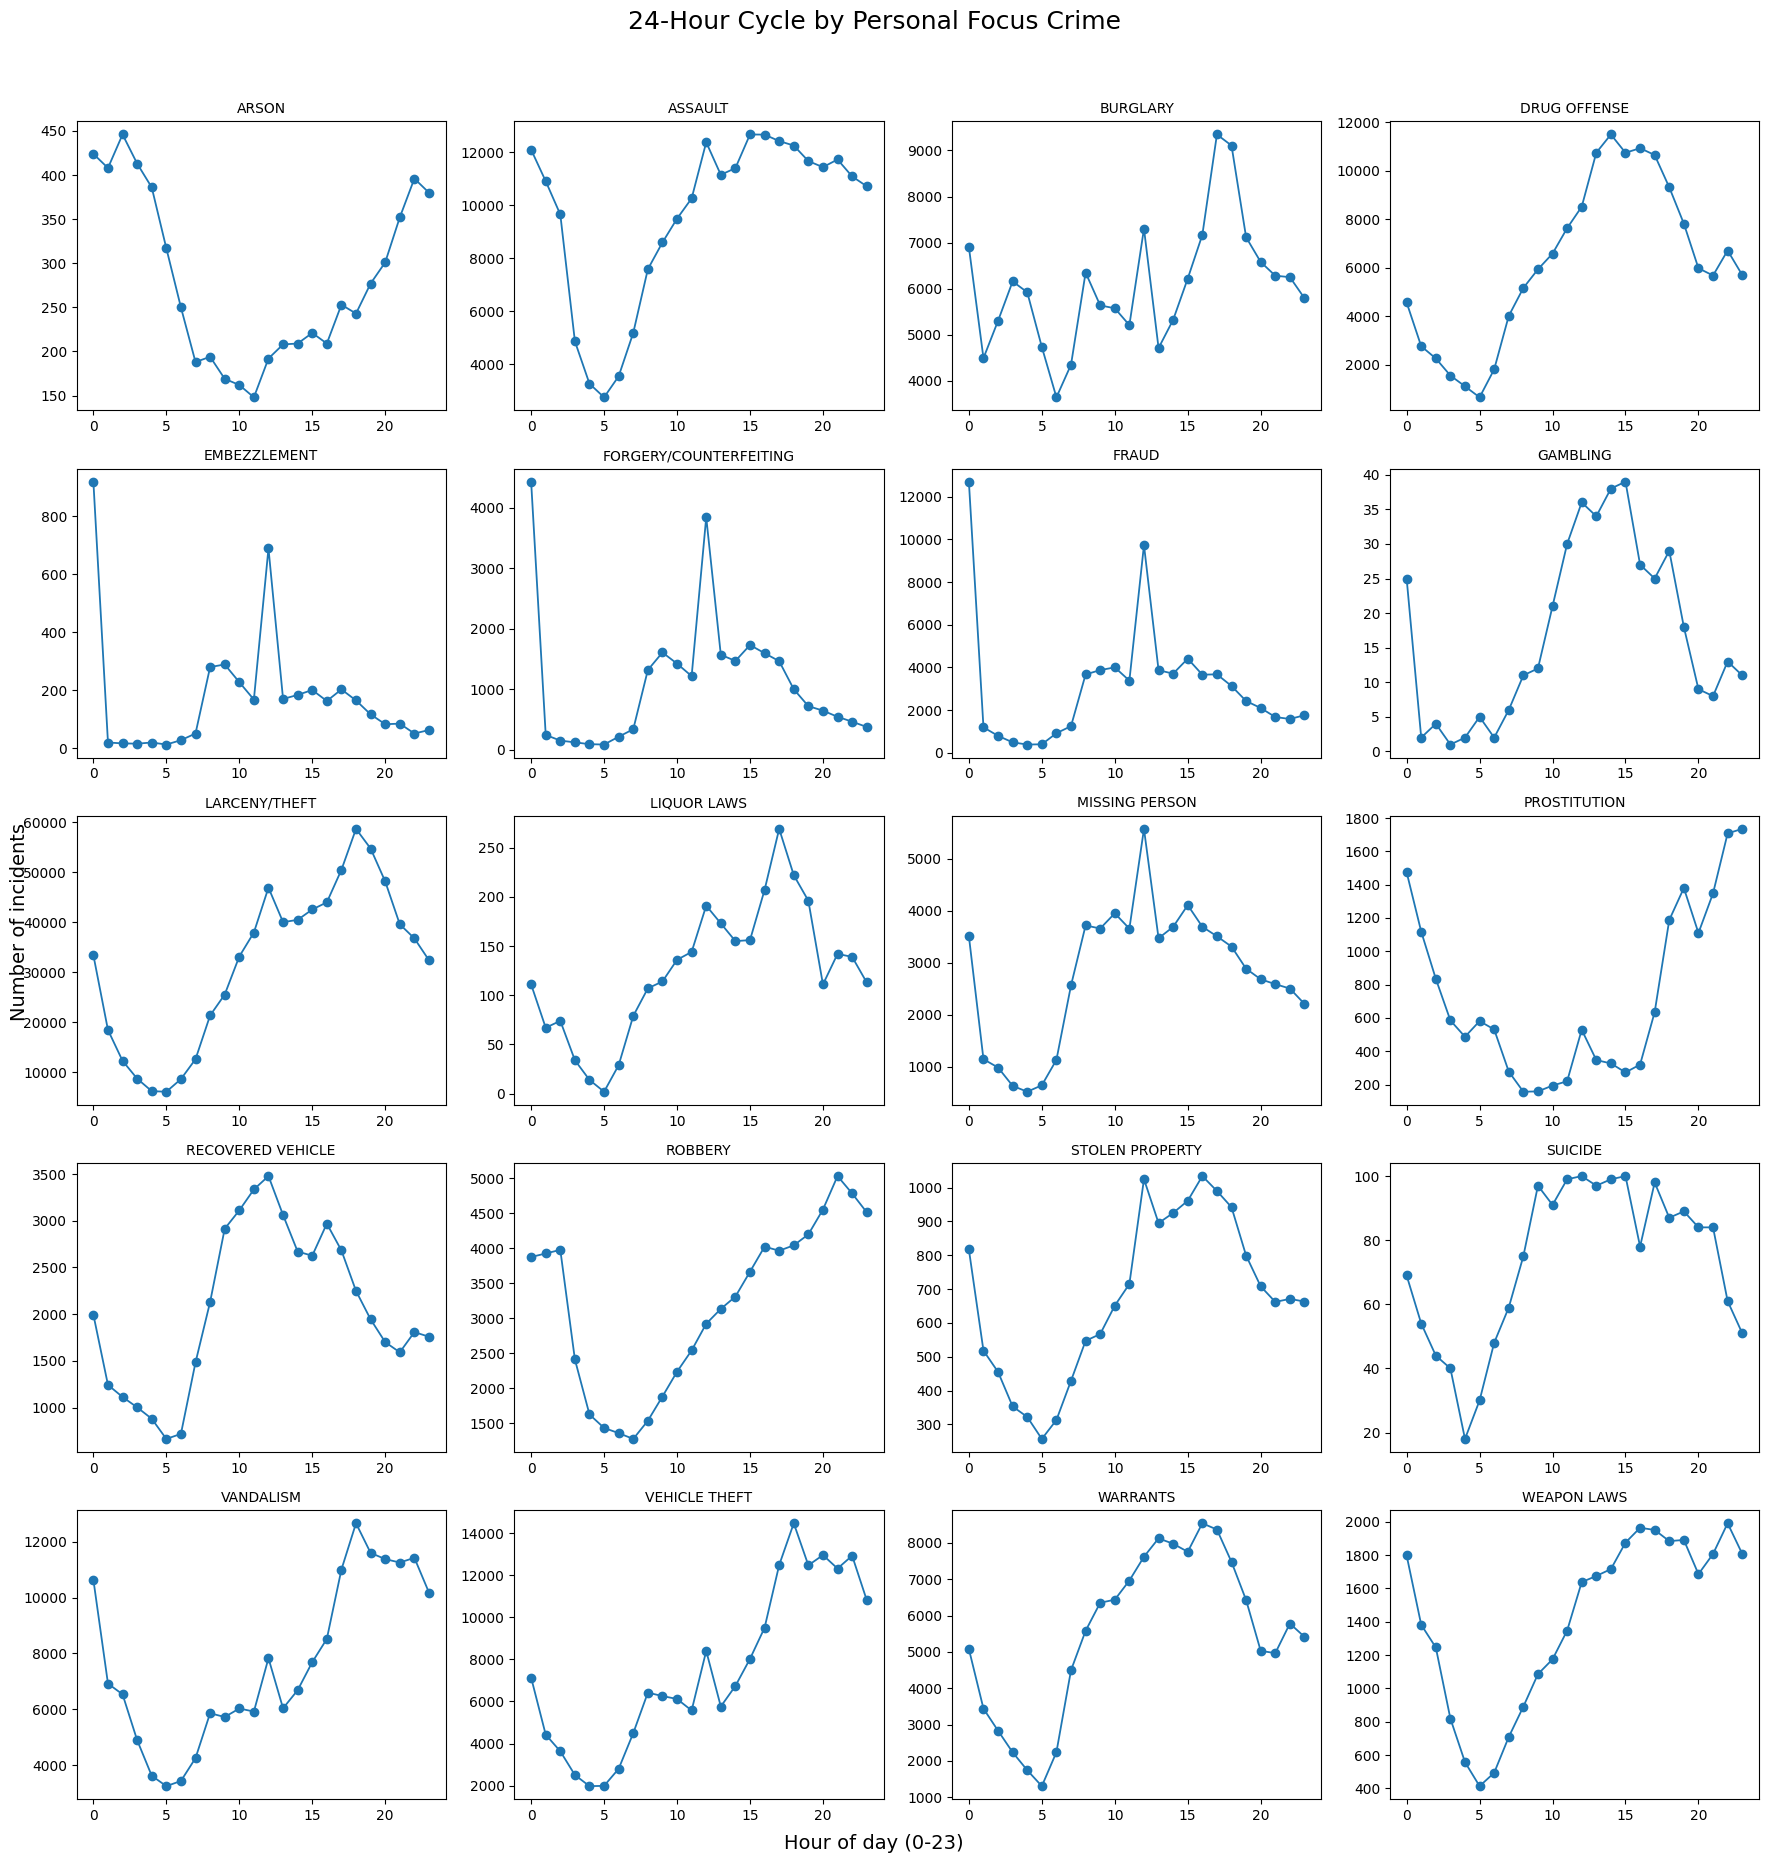

In [74]:
# 4) 24-hour cycle
plot_focus_grid(
    merged_focus_final,
    x_col="hour",
    x_label="Hour of day (0-23)",
    plot_kind="line",
    x_order=list(range(24)),
    title_prefix="24-Hour Cycle by Personal Focus Crime"
)

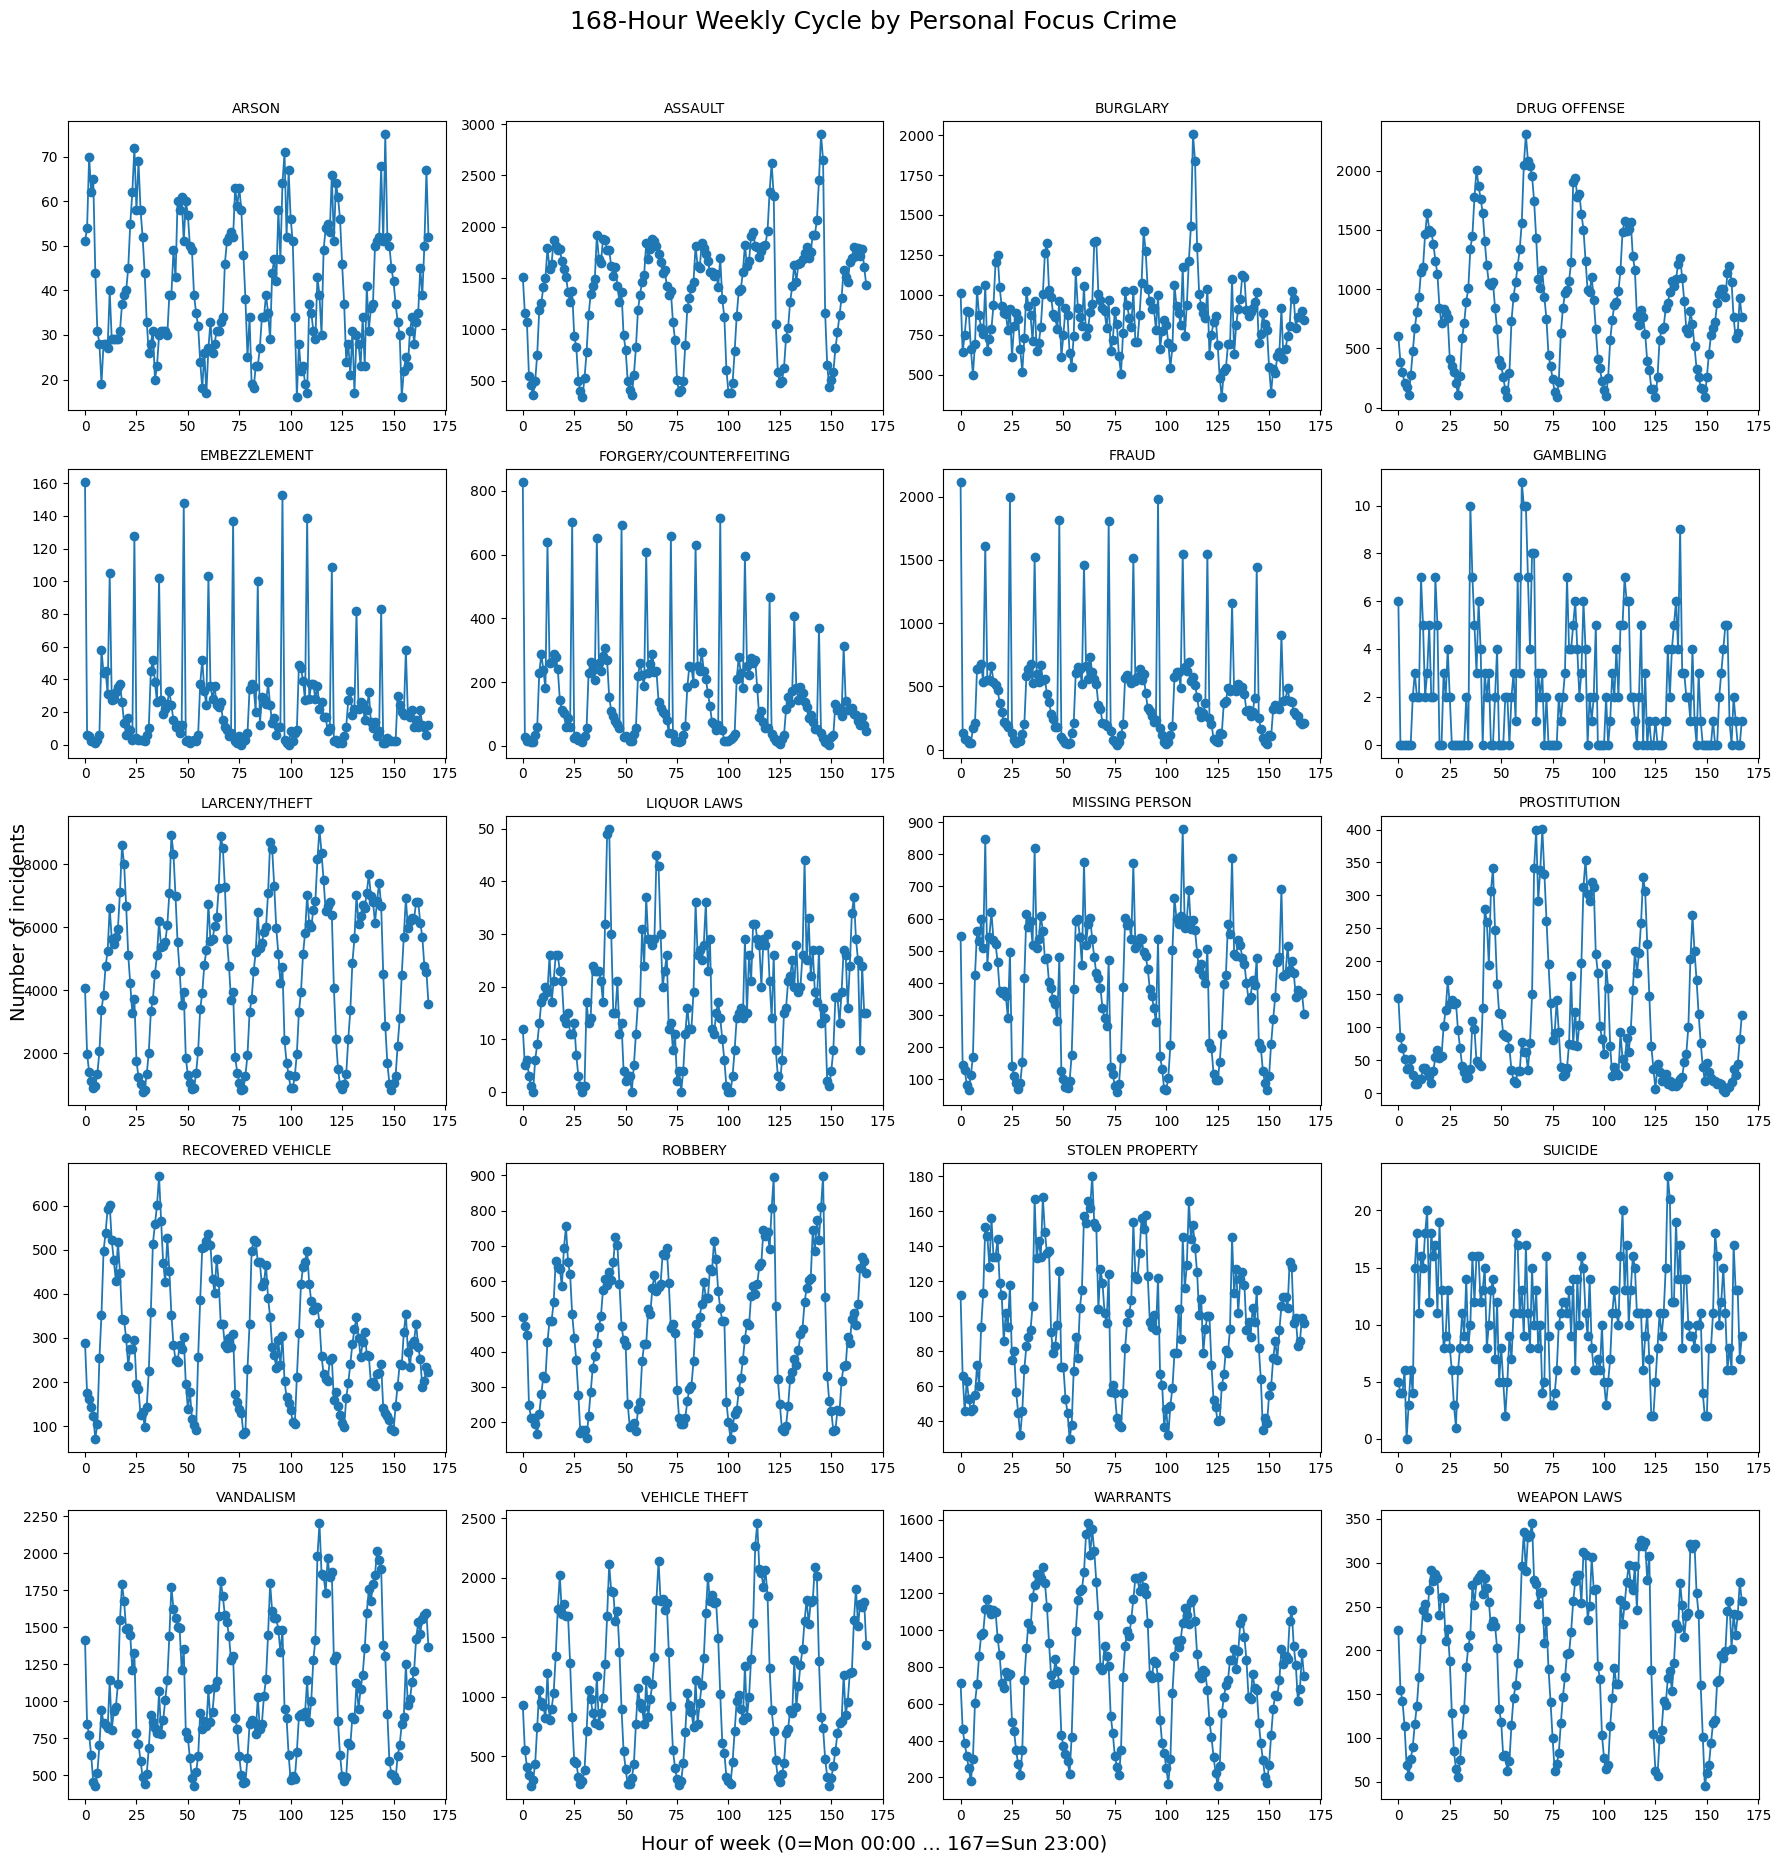

In [75]:
# 5) 168 hours of week
plot_focus_grid(
    merged_focus_final,
    x_col="hour_of_week",
    x_label="Hour of week (0=Mon 00:00 ... 167=Sun 23:00)",
    plot_kind="line",
    x_order=list(range(168)),
    title_prefix="168-Hour Weekly Cycle by Personal Focus Crime"
)

## Part 4: Exploring other types of plots for temporal data

We now take a mini-break from barcharts and exploring more ways to plot temporal data.

> **Exercise 4.1**: Other cool ways to plot temporal data
>
> I am going to introduce four different plot-types. Then your job is to choose a part of the crime-data that you care about and plot it using these new ways of visualizing data. I recommend that you choose a different part of the crime-data for each plot-type.
>
> * **Calendar plots**. Get started on calendar plots **[here](https://calplot.readthedocs.io/en/latest/)**. There are other packages for plotting these, those are also OK to use.
> * **Polar bar chart**. Here I want you to plot a 24-hour pattern of some sort — those work really well in radial plots (another name for polar plots) because the day wraps around on itself. You can also try plotting data with patterns from the 168 hours of the week. There's not one super-awesome solution here, you can try using [pure matplotlib](https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html) ... [some examples here](https://www.python-graph-gallery.com/circular-barplot/) or via [plotly](https://plotly.com/python/polar-chart/) (scroll down a bit for the polar barchart).
> * **Time series**. Time series is a key functionality of Pandas. To get started, check out the [pandas time series documentation](https://pandas.pydata.org/docs/user_guide/timeseries.html) and the guide on [plotting with a DatetimeIndex](https://pandas.pydata.org/docs/user_guide/visualization.html#plotting-with-a-datetimeindex). For resampling data to different time frequencies (daily, weekly, monthly), see [DataFrame.resample()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html).
> * **Heatmaps**. A heatmap showing hour-of-day vs day-of-week is a classic way to visualize temporal patterns. This pairs nicely with your 168-hour analysis from Exercise 3.1. Get started with [seaborn.heatmap()](https://seaborn.pydata.org/generated/seaborn.heatmap.html) — you'll need to pivot your data into a matrix first.
> * **Reflection**: What did you learn from using LLMs to solve these visualization challenges?

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> For this exercise, you may use the full power of your LLM! Go nuts and see if you can get these plots working by fully relying on LLM-generated code. This is a deliberate contrast to the previous exercises — afterward, reflect on what was different about this experience.
</div>

**Note**: I added this exercise with fewer hints than usual. Normally, I help you break down the problems into small solvable bits. Since this is an LLM-heavy exercise, I haven't done that. But I encourage you to play with figuring out the steps yourself — and compare your breakdown to what the LLM suggests.

This ties into a bigger picture thing about data science.

*My philosophy for data science is this*: Getting to what you want rarely seems hard once you found your way there, the difficulty comes in breaking down a hard problem into the little steps you need to take to solve your complex problem. In this class, I usually do the breaking down for you and provide you with the steps (that's how you go from nothing to creating complex visualizations of crime-data). But I also want you to learn the breaking-problems-down part. LLMs can help here - they can tell you how to break down problems into smaller bits - but if you don't try yourself, you'll never get good at it. So always create your own breakdown first; then see what the computer thinks.

*My approach is always to think something along these lines*: Even if my task seems impossible, I think: "is there any problem that I ***CAN*** solve that will get me closer to where I want to go?" Once I've solved that part, I'm smarter and I try to think: "Is there a new problem I can solve that'll get me closer knowing what I know now?" And I just keep going. Usually that's enough.

In [76]:
# Part 4 - Setup and fixed plot strategy (single source dataframe)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df4 = merged_focus_final.copy()
df4["dt"] = pd.to_datetime(df4["incident_datetime"], errors="coerce")
df4 = df4[df4["dt"].notna()].copy()

# Fixed crime selection for each plot type (edit only these if needed)
crime_calendar = "LARCENY/THEFT"
crime_polar = "ROBBERY"
crime_heatmap = "DRUG/NARCOTIC"
crimes_timeseries = ["LARCENY/THEFT", "DRUG/NARCOTIC", "VEHICLE THEFT", "ROBBERY"]


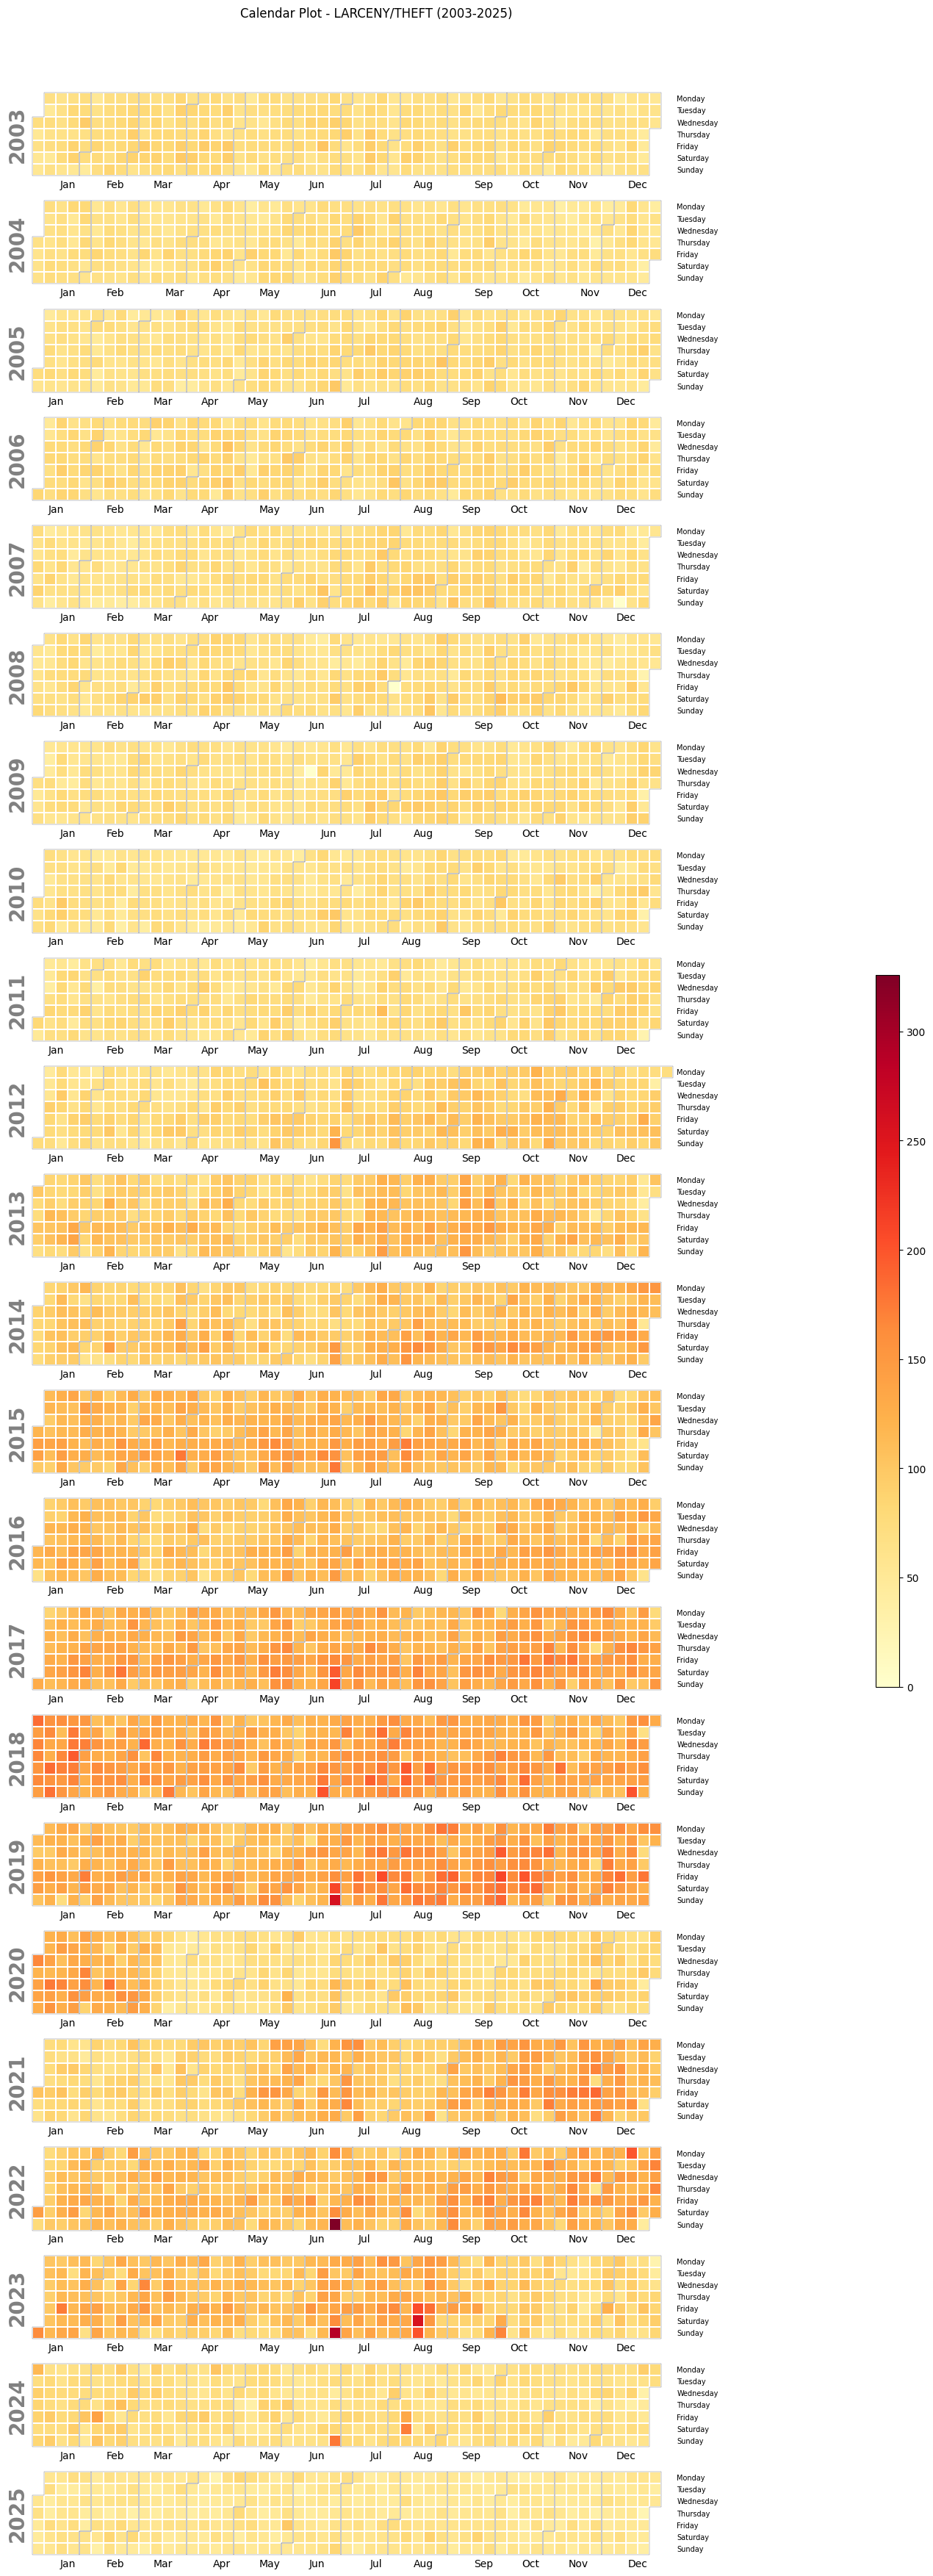

In [77]:
# Calendar plot tuned:
# - different colormap
# - smaller colorbar
# - all weekdays shown with smaller font
# - suppress Helvetica findfont spam

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging
import calplot

# 1) Stop font-manager spam and force installed fonts
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["DejaVu Sans", "Arial", "Liberation Sans"]

# 2) Data (full 2003-2025, complete daily index)
daily_all = (
    df4.loc[
        (df4["personal_focus_crime"] == crime_calendar)
        & (df4["dt"] >= "2003-01-01")
        & (df4["dt"] < "2026-01-01")
    ]
    .set_index("dt")
    .resample("D")
    .size()
)
daily_all = daily_all.reindex(pd.date_range("2003-01-01", "2025-12-31", freq="D"), fill_value=0)

# 3) Plot
fig, axes = calplot.calplot(
    daily_all,
    how=None,
    cmap="YlOrRd",  # back to previous warm scale
    fillcolor="whitesmoke",
    linewidth=0.35,
    linecolor="white",
    yearlabels=True,
    yearlabel_kws={"fontsize": 20, "fontweight": "bold"},  # only years bigger
    daylabels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    dayticks=[0, 1, 2, 3, 4, 5, 6],
    monthlabels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
    monthlabeloffset=15,
    colorbar=True,
    suptitle=f"Calendar Plot - {crime_calendar} (2003-2025)",
    figsize=(16, 34),
)

# keep weekday/month sizes exactly as before
for ax in fig.axes[:-1]:
    ax.tick_params(axis="y", labelsize=7)
    ax.tick_params(axis="x", labelsize=10)

# keep compact colorbar
cax = fig.axes[-1]
p = cax.get_position()
cax.set_position([p.x0, p.y0 + p.height * 0.35, p.width, p.height * 0.30])

plt.show()


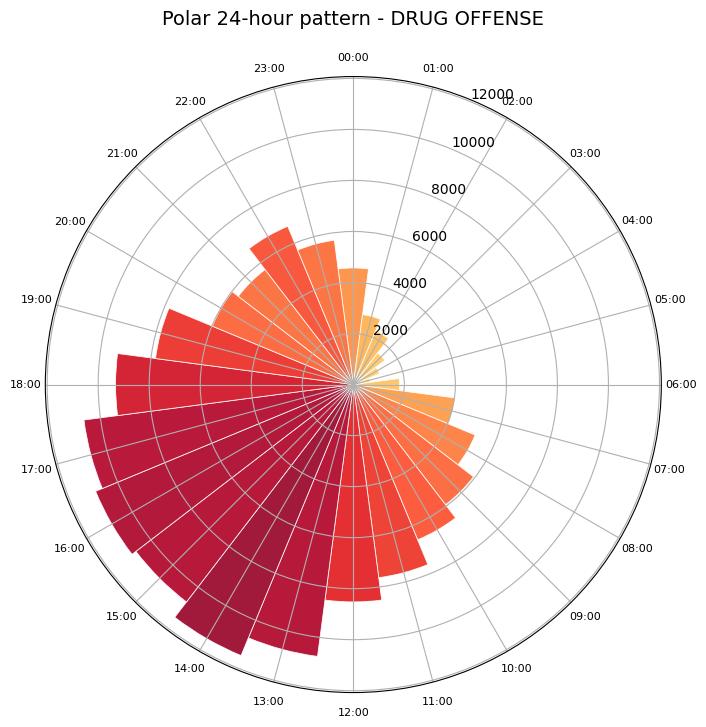

In [78]:
# Polar bar chart (matplotlib version) for one crime
# Start with ROBBERY (change crime_polar_target to "ASSAULT" if preferred)

import numpy as np
import matplotlib.pyplot as plt

crime_polar_target = "DRUG OFFENSE"

hour_counts = (
    df4[df4["personal_focus_crime"] == crime_polar_target]
    .groupby(df4["dt"].dt.hour)
    .size()
    .reindex(range(24), fill_value=0)
)

theta = np.linspace(0, 2 * np.pi, 24, endpoint=False)
r = hour_counts.values
width = 2 * np.pi / 24

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="polar")
bars = ax.bar(theta, r, width=width, bottom=0.0, alpha=0.9, edgecolor="white", linewidth=0.6)

# Color bars by intensity
norm = (r - r.min()) / (r.max() - r.min() + 1e-9)
for b, n in zip(bars, norm):
    b.set_facecolor(plt.cm.YlOrRd(0.25 + 0.7 * n))

ax.set_theta_zero_location("N")   # 00:00 at top
ax.set_theta_direction(-1)        # clockwise
ax.set_xticks(theta)
ax.set_xticklabels([f"{h:02d}:00" for h in range(24)], fontsize=8)
ax.set_title(f"Polar 24-hour pattern - {crime_polar_target}", pad=20, fontsize=14)

plt.show()

In [79]:
# Same version + hide 6000 label + slightly better contrast (without loud background)
import plotly.express as px

crime_polar_target = "ROBBERY"

polar_df = (
    df4[df4["personal_focus_crime"] == crime_polar_target]
    .assign(hour=lambda d: d["dt"].dt.hour)
    .groupby("hour")
    .size()
    .reindex(range(24), fill_value=0)
    .rename("count")
    .reset_index()
)

polar_df["hour_label"] = polar_df["hour"].map(lambda h: f"{h:02d}:00")

fig = px.bar_polar(
    polar_df,
    r="count",
    theta="hour_label",
    color="count",
    color_continuous_scale="YlOrRd",
    template="plotly_white",
)

fig.update_traces(
    marker_line_color="white",
    marker_line_width=1.7,
    opacity=0.96,
    hovertemplate="Hour: %{theta}<br>Incidents: %{r}<extra></extra>"
)

max_r = int(np.ceil(polar_df["count"].max() / 1000.0) * 1000)

# Hide outermost radial label (e.g., 6000)
tickvals = list(range(0, max_r + 1, 1000))
ticktext = [str(v) for v in tickvals]
ticktext[-1] = ""

fig.update_layout(
    title=dict(
        text=f"24-hour circular pattern ({crime_polar_target})",
        x=0.5,
        xanchor="center",
        y=0.96,
        font=dict(size=34, color="#213a5b")
    ),
    width=1200,
    height=900,
    margin=dict(l=60, r=120, t=120, b=50),
    font=dict(size=15, color="#2b3f5f"),
    showlegend=False,
    paper_bgcolor="white",
    plot_bgcolor="white",
    coloraxis_colorbar=dict(
        title=dict(text="Incidents", font=dict(size=16)),
        len=0.52,
        thickness=20,
        y=0.5,
        yanchor="middle",
        tickfont=dict(size=13),
    ),
    polar=dict(
        domain=dict(x=[0.09, 0.84], y=[0.08, 0.94]),
        bgcolor="#e8edf5",  # slightly darker neutral than before
        angularaxis=dict(
            direction="clockwise",
            rotation=90,
            tickfont=dict(size=11),
            ticks="",
            showline=True,
            linecolor="rgba(90,110,140,0.85)",
            linewidth=2.2,
            gridcolor="rgba(255,255,255,1.0)",  # pure white radial lines
            gridwidth=1.25
        ),
        radialaxis=dict(
            range=[0, max_r],
            tickvals=tickvals,
            ticktext=ticktext,
            tickfont=dict(size=12),
            angle=25,
            showline=False,
            gridcolor="rgba(255,255,255,1.0)",  # pure white circles
            gridwidth=1.25
        ),
    ),
)

fig.show()


In [80]:
# Same plot, radial circles every 3000 incidents

crime_polar_target = "ASSAULT"

polar_df = (
    df4[df4["personal_focus_crime"] == crime_polar_target]
    .assign(hour=lambda d: d["dt"].dt.hour)
    .groupby("hour")
    .size()
    .reindex(range(24), fill_value=0)
    .rename("count")
    .reset_index()
)

polar_df["hour_label"] = polar_df["hour"].map(lambda h: f"{h:02d}:00")

fig = px.bar_polar(
    polar_df,
    r="count",
    theta="hour_label",
    color="count",
    color_continuous_scale="YlOrRd",
    template="plotly_white",
)

fig.update_traces(
    marker_line_color="white",
    marker_line_width=1.6,
    opacity=0.96,
    hovertemplate="Hour: %{theta}<br>Incidents: %{r}<extra></extra>"
)

# 3k step for radial rings
step = 3000
max_r = int(np.ceil(polar_df["count"].max() / step) * step)
tickvals = list(range(0, max_r + 1, step))
ticktext = [str(v) for v in tickvals]
ticktext[-1] = ""  # hide outermost label

fig.update_layout(
    title=dict(
        text=f"24-hour circular pattern ({crime_polar_target})",
        x=0.5,
        xanchor="center",
        y=0.96,
        font=dict(size=34, color="#213a5b")
    ),
    width=1200,
    height=900,
    margin=dict(l=60, r=120, t=120, b=50),
    font=dict(size=15, color="#2b3f5f"),
    showlegend=False,
    paper_bgcolor="white",
    plot_bgcolor="white",
    coloraxis_colorbar=dict(
        title=dict(text="Incidents", font=dict(size=16)),
        len=0.52,
        thickness=20,
        y=0.5,
        yanchor="middle",
        tickfont=dict(size=13),
    ),
    polar=dict(
        domain=dict(x=[0.09, 0.84], y=[0.08, 0.94]),
        bgcolor="white",
        angularaxis=dict(
            direction="clockwise",
            rotation=90,
            tickfont=dict(size=11),
            ticks="",
            showline=True,
            linecolor="rgba(90,110,140,0.85)",
            linewidth=2.2,
            gridcolor="rgba(130,145,165,0.35)",
            gridwidth=1.0
        ),
        radialaxis=dict(
            range=[0, max_r],
            tickvals=tickvals,
            ticktext=ticktext,
            tickfont=dict(size=12),
            angle=25,
            showline=False,
            gridcolor="rgba(130,145,165,0.35)",
            gridwidth=1.0
        ),
    ),
)

fig.show()

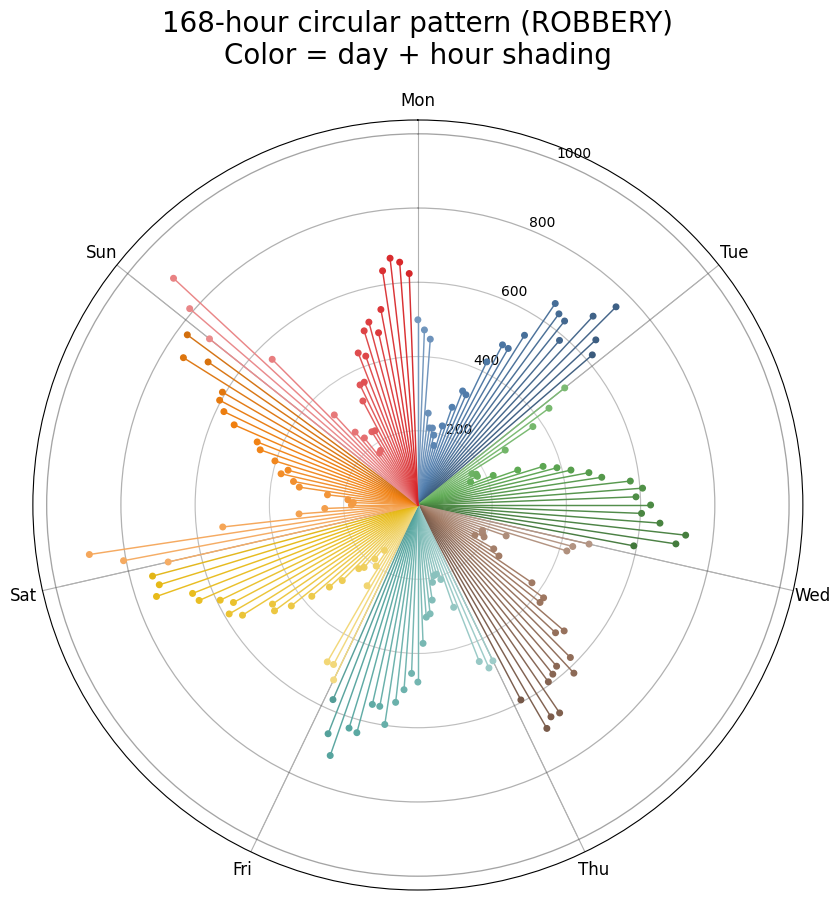

In [81]:
# 168-hour circular lollipop (ROBBERY)
# Color = day hue + light/dark by hour within each day

crime_polar_target = "ROBBERY"

tmp = df4[df4["personal_focus_crime"] == crime_polar_target].copy()
tmp["weekday"] = tmp["dt"].dt.dayofweek
tmp["hour"] = tmp["dt"].dt.hour
tmp["hour_of_week"] = tmp["weekday"] * 24 + tmp["hour"]

counts = tmp.groupby("hour_of_week").size().reindex(range(168), fill_value=0)

theta = np.linspace(0, 2*np.pi, 168, endpoint=False)
r = counts.values
day_idx = np.array([h // 24 for h in range(168)])
hour_idx = np.array([h % 24 for h in range(168)])

# base day colors
day_palette = {
    0: "#4e79a7",  # Mon
    1: "#59a14f",  # Tue
    2: "#9c755f",  # Wed
    3: "#76b7b2",  # Thu
    4: "#edc948",  # Fri
    5: "#f28e2b",  # Sat
    6: "#e15759",  # Sun
}

# light/dark modulation by hour (early lighter -> late darker)
import colorsys
def shade_by_hour(hex_color, hour):
    h = hex_color.lstrip("#")
    r0, g0, b0 = tuple(int(h[i:i+2], 16) / 255 for i in (0, 2, 4))
    H, L, S = colorsys.rgb_to_hls(r0, g0, b0)
    # hour 0 -> +light, hour 23 -> -light
    delta = np.interp(hour, [0, 23], [0.12, -0.12])
    L2 = min(0.90, max(0.22, L + delta))
    r1, g1, b1 = colorsys.hls_to_rgb(H, L2, S)
    return (r1, g1, b1)

colors_day_hour = np.array([shade_by_hour(day_palette[d], h) for d, h in zip(day_idx, hour_idx)])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="polar")
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# stems + heads
for t, rv, c in zip(theta, r, colors_day_hour):
    ax.plot([t, t], [0, rv], color=c, linewidth=1.05, alpha=0.96, zorder=2)
ax.scatter(theta, r, c=colors_day_hour, s=16, zorder=3)

# day separators
rmax = r.max() * 1.1
for d in range(7):
    ax.plot([2*np.pi*d/7, 2*np.pi*d/7], [0, rmax], color="gray", lw=0.7, alpha=0.65, zorder=1)

# day labels
ax.set_xticks([2*np.pi*(d*24)/168 for d in range(7)])
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], fontsize=12)

# radial ticks and labels
max_tick = int(np.ceil(r.max() / 200.0) * 200)
rticks = np.arange(200, max_tick + 1, 200)
ax.set_yticks(rticks)
ax.set_yticklabels([str(v) for v in rticks], fontsize=10)  # slightly bigger than previous
ax.set_rlabel_position(22)

# radial rings with clearer separation
for gl, v in zip(ax.yaxis.get_gridlines(), rticks):
    frac = v / max_tick
    gl.set_color("#4a4a4a")
    gl.set_alpha(0.15 + 0.35 * frac)
    gl.set_linewidth(0.7 + 0.25 * frac)

ax.set_title(
    f"168-hour circular pattern ({crime_polar_target})\nColor = day + hour shading",
    pad=20,
    fontsize=20
)

plt.show()

In [82]:
# Time series base (exclude 2026+)
ts = merged_focus_final.copy()
ts["dt"] = pd.to_datetime(ts["incident_datetime"], errors="coerce")
ts = ts[ts["dt"].notna() & (ts["dt"].dt.year <= 2025)].copy()
ts = ts.set_index("dt").sort_index()

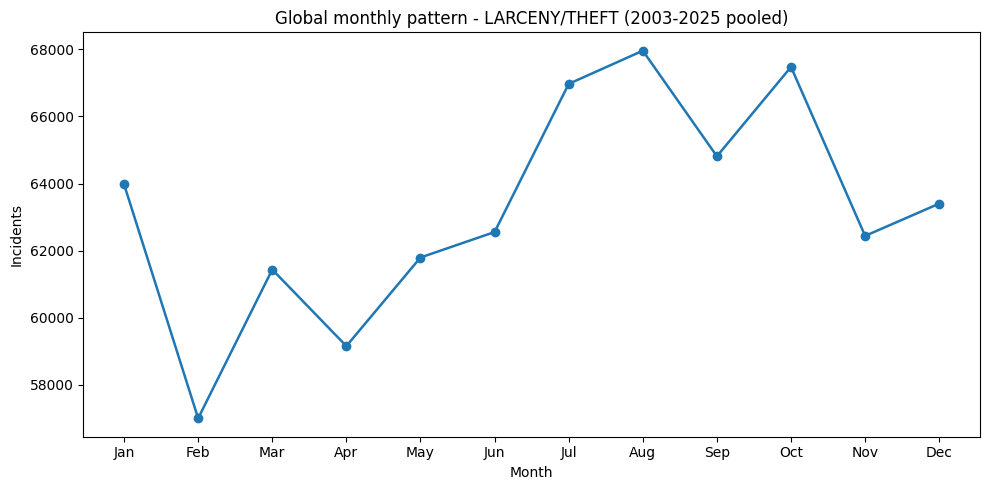

In [83]:
# Global monthly pattern (all years pooled, through 2025) for one crime

crime_monthly_global = "LARCENY/THEFT"   # or "WEAPON LAWS"

monthly_global = (
    ts[ts["personal_focus_crime"] == crime_monthly_global]
    .groupby(ts[ts["personal_focus_crime"] == crime_monthly_global].index.month)
    .size()
    .reindex(range(1, 13), fill_value=0)
)

plt.figure(figsize=(10, 5))
plt.plot(monthly_global.index, monthly_global.values, marker="o", linewidth=1.8)
plt.xticks(range(1, 13), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.title(f"Global monthly pattern - {crime_monthly_global} (2003-2025 pooled)")
plt.xlabel("Month")
plt.ylabel("Incidents")
plt.tight_layout()
plt.show()

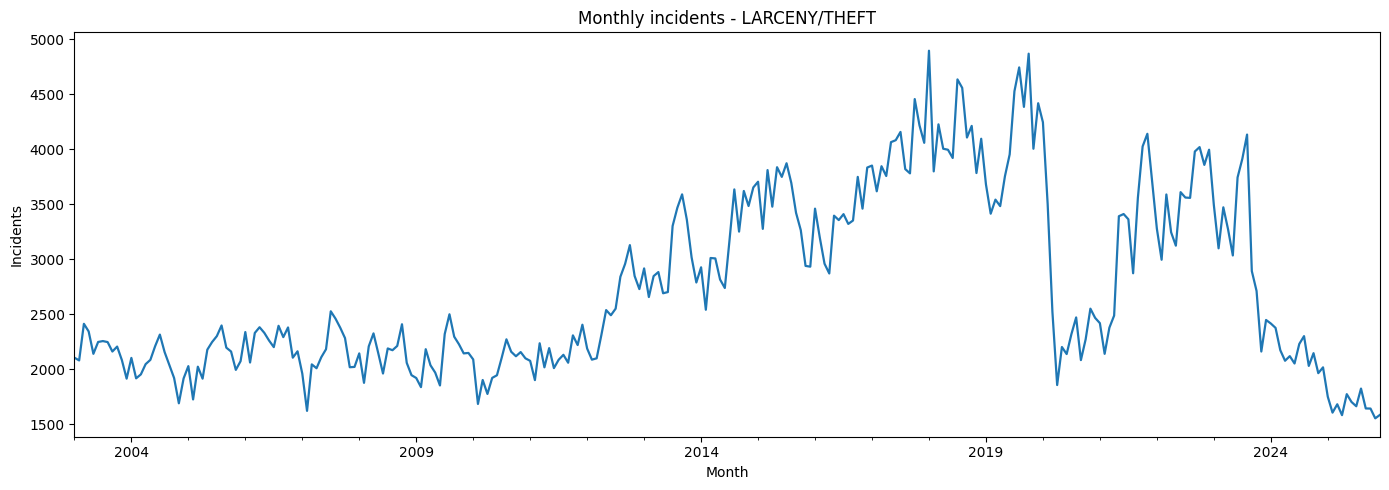

In [84]:
# Monthly time series - LARCENY/THEFT
crime_monthly = "LARCENY/THEFT"

monthly = (
    ts[ts["personal_focus_crime"] == crime_monthly]
    .resample("ME")
    .size()
    .rename("n")
)

plt.figure(figsize=(14, 5))
monthly.plot(linewidth=1.6)
plt.title(f"Monthly incidents - {crime_monthly}")
plt.xlabel("Month")
plt.ylabel("Incidents")
plt.tight_layout()
plt.show()

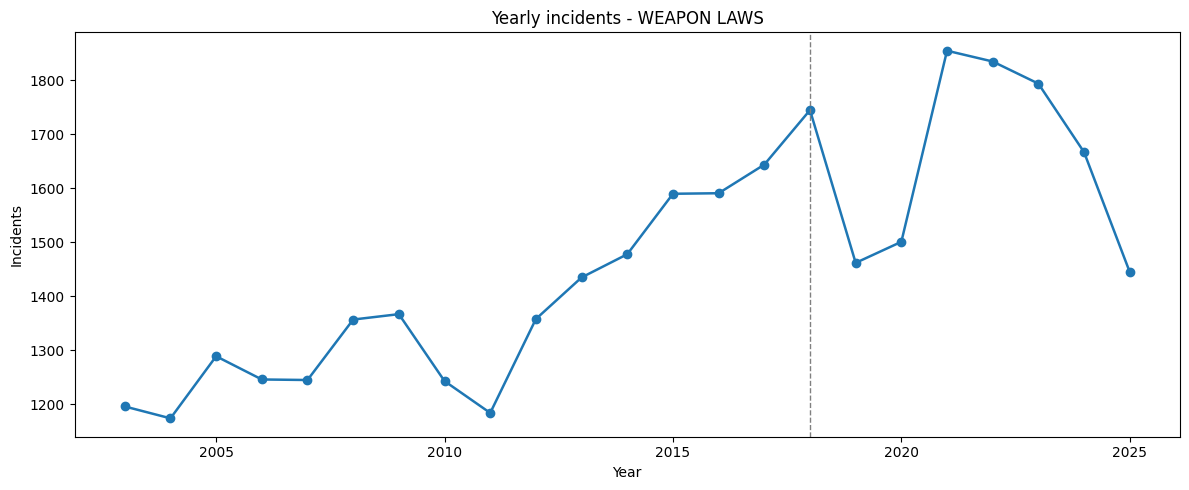

In [85]:
# Yearly time series - WEAPON LAWS
crime_yearly = "WEAPON LAWS"

yearly = (
    ts[ts["personal_focus_crime"] == crime_yearly]
    .resample("YE")
    .size()
    .rename("n")
)

yearly.index = yearly.index.year

plt.figure(figsize=(12, 5))
plt.plot(yearly.index, yearly.values, marker="o", linewidth=1.8)
plt.axvline(2018, linestyle="--", color="gray", linewidth=1)
plt.title(f"Yearly incidents - {crime_yearly}")
plt.xlabel("Year")
plt.ylabel("Incidents")
plt.tight_layout()
plt.show()

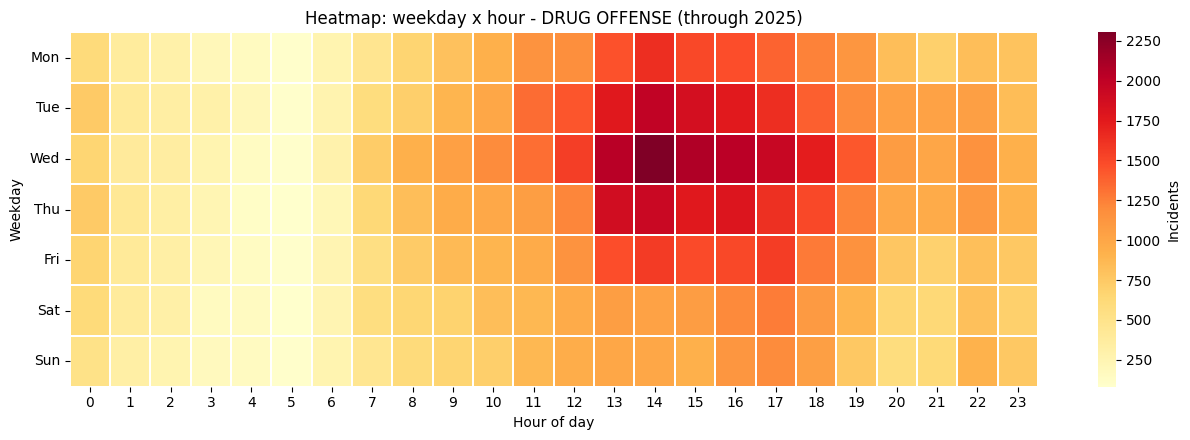

In [86]:
# Heatmap (weekday x hour) for one crime, using same time filter (<=2025)

crime_heatmap = "DRUG OFFENSE"  # change if you want

hm = ts[ts["personal_focus_crime"] == crime_heatmap].copy()
hm["weekday"] = hm.index.dayofweek   # Mon=0 ... Sun=6
hm["hour"] = hm.index.hour

mat = (
    hm.groupby(["weekday", "hour"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=range(7), columns=range(24), fill_value=0)
)

plt.figure(figsize=(13, 4.5))
sns.heatmap(
    mat,
    cmap="YlOrRd",
    linewidths=0.25,
    linecolor="white",
    cbar_kws={"label": "Incidents"}
)
plt.title(f"Heatmap: weekday x hour - {crime_heatmap} (through 2025)")
plt.xlabel("Hour of day")
plt.ylabel("Weekday")
plt.yticks(
    ticks=np.arange(7) + 0.5,
    labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    rotation=0
)
plt.tight_layout()
plt.show()

In [87]:
## Final adjustments of merged dataset before export (e.g. drop intermediate columns, reorder, etc.) and export to CSV for next exercises

# In this merged dataset, rows are already Personal Focus Crimes from Week 2.
# Keep only final crime label for analysis
merged_focus_final = merged_focus_final.drop(columns=["cat_norm", "crime_key"], errors="ignore")

# Clean district + remove redundant district/time helper columns

# 1) Keep only rows with district
merged_focus_final = merged_focus_final[merged_focus_final["police_district"].notna()].copy()

# 2) Normalize police_district
merged_focus_final["police_district"] = (
    merged_focus_final["police_district"]
    .astype(str)
    .str.strip()
    .str.upper()
)

# 3) Remove district_key (we keep normalized police_district as the single district column)
if "district_key" in merged_focus_final.columns:
    merged_focus_final = merged_focus_final.drop(columns=["district_key"])

# 4) Remove redundant datetime helper columns (keep incident_datetime as main time field)
time_redundant = [
    "dt", "dt_key"
]
merged_focus_final = merged_focus_final.drop(columns=[c for c in time_redundant if c in merged_focus_final.columns])

#Fix latitude/longitude decimal commas once (global cleanup for this notebook section)

merged_focus_final["latitude"] = pd.to_numeric(
    merged_focus_final["latitude"].astype(str).str.replace(",", ".", regex=False),
    errors="coerce"
)

merged_focus_final["longitude"] = pd.to_numeric(
    merged_focus_final["longitude"].astype(str).str.replace(",", ".", regex=False),
    errors="coerce"
)

out_path = Path(r"C:\Users\slupo\OneDrive\Documentos\DTU\Social data analysis and visualization") / "sf_crime_merged_focus_2003_2025.csv"
merged_focus_final.to_csv(out_path, index=False)

---

## You've Completed Week 2!

This week you tackled one of the messiest but most important skills in data science: merging imperfect datasets. You now have:

- A unified crime dataset spanning 2003 to the present
- Experience with schema mapping and category matching
- A documented set of Personal Focus Crimes that you can track confidently over time
- New visualization techniques (calendar plots, polar charts, time series)

**Key takeaways:**
- Real-world data is messy. Categories change, formats differ, and documentation is often missing.
- The assumptions you make during data cleaning directly affect what conclusions you can draw.
- Validation is crucial — always check that your merged data makes sense at the boundaries.
- Understanding *why* data looks the way it does is just as important as knowing *how* to process it.

If you want to go further:
- Explore spatial patterns in your merged dataset — which neighborhoods show the most change over 20 years? Do any neighborhoods have different patterns than the city as a whole?
- Try different category mappings and see how they affect your conclusions
- Look for "structural breaks" — points where the data changes in ways that might reflect policy changes, not actual crime changes
- Compare your Personal Focus Crimes list with a classmate's — did you make different choices? Why?